In [1]:
import os
import gc
import json
import glob
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import seaborn as sns
import tqdm

import torchvision
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision import transforms

import PIL
from PIL import Image, ImageDraw
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from IPython.display import clear_output

In [2]:
# Бинарный поиск для приближения предсказанной маски 4-хугольником
def simplify_contour(contour, n_corners=4):
    n_iter, max_iter = 0, 1000
    lb, ub = 0., 1.

    while True:
        n_iter += 1
        if n_iter > max_iter:
            print('simplify_contour didnt coverege')
            return None

        k = (lb + ub)/2.
        eps = k*cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, eps, True)

        if len(approx) > n_corners:
            lb = (lb + ub)/2.
        elif len(approx) < n_corners:
            ub = (lb + ub)/2.
        else:
            return approx

# Отображаем 4-хугольник в прямоугольник 
# Спасибо ulebok за идею 
# И вот этим ребятам за реализацию: https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/
def four_point_transform(image, pts):
    
    rect = order_points(pts)
    
    tl, tr, br, bl = pts
    
    width_1 = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    width_2 = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    max_width = max(int(width_1), int(width_2))
    
    height_1 = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    height_2 = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    max_height = max(int(height_1), int(height_2))
    
    dst = np.array([
        [0, 0],
        [max_width, 0],
        [max_width, max_height],
        [0, max_height]], dtype = "float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (max_width, max_height))
    return warped

def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect


# Визуализируем детекцию (4 точки, bounding box и приближенный по маске контур)
def visualize_prediction_plate(file, model, device='cuda', verbose=True, thresh=0.0, 
                               n_colors=None, id_to_name=None):
    img = Image.open(file)
    img_tensor = my_transforms(img)
    model.to(device)
    model.eval()
    with torch.no_grad():
        predictions = model([img_tensor.to(device)])
    prediction = predictions[0]
    
    if n_colors is None:
        n_colors = model.roi_heads.box_predictor.cls_score.out_features
    
    palette = sns.color_palette(None, n_colors)
    
    img = cv2.imread(file, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    image = img
    
    blackImg = np.zeros(image.shape, image.dtype)
    blackImg[:,:] = (0, 0, 0)
    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        mask = prediction['masks'][i][0, :, :].cpu().numpy()
        name = id_to_name[label]
        color = palette[label]
        
        if verbose:
            if score > thresh:
                print ('Class: {}, Confidence: {}'.format(name, score))
        if score > thresh:            
            crop_img = image[y_min:y_max, x_min:x_max]
            print('Bounding box:')
            show_image(crop_img, figsize=(10, 2))
            
            # В разных версиях opencv этот метод возвращает разное число параметров
            # contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
            _,contours,_ = cv2.findContours((mask > 0.05).astype(np.uint8), 1, 1)
            approx = simplify_contour(contours[0], n_corners=4)
            
            if approx is None:
                x0, y0 = x_min, y_min
                x1, y1 = x_max, y_min
                x2, y2 = x_min, y_max
                x3, y3 = x_max, y_max
#                 points = [[x_min, y_min], [x_min, y_max], [x_max, y_min],[x_max, y_max]]
            else:
                x0, y0 = approx[0][0][0], approx[0][0][1]
                x1, y1 = approx[1][0][0], approx[1][0][1]
                x2, y2 = approx[2][0][0], approx[2][0][1]
                x3, y3 = approx[3][0][0], approx[3][0][1]
                
            points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]
            
            
            points = np.array(points)
            crop_mask_img = four_point_transform(img, points)
            print('Rotated img:')
            crop_mask_img = cv2.resize(crop_mask_img, (320, 64), interpolation=cv2.INTER_AREA)
            show_image(crop_mask_img, figsize=(10, 2))
            if approx is not None:
                cv2.drawContours(image, [approx], 0, (255,0,255), 3)
            image = cv2.circle(image, (x0, y0), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x1, y1), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x2, y2), radius=5, color=(0, 0, 255), thickness=-1)
            image = cv2.circle(image, (x3, y3), radius=5, color=(0, 0, 255), thickness=-1)
            
            image = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), np.array(color) * 255, 2)
            
    show_image(image)
    return prediction

# Просто показать картинку. С семинара
def show_image(image, figsize=(16, 9), reverse=True):
    plt.figure(figsize=figsize)
    if reverse:
        plt.imshow(image[...,::-1])
    else:
        plt.imshow(image)
    plt.axis('off')
    plt.show()
    

# Переводит предсказания модели в текст. С семинара
def decode(pred, alphabet):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], alphabet))
    return outputs

def pred_to_string(pred, alphabet):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([alphabet[c] for c in out])
    return out
    

        
def load_json(file):
    with open(file, 'r') as f:
        return json.load(f)
    
# Чтобы без проблем сериализовывать json. Без него есть нюансы
class npEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.int32):
            return int(obj)
        return json.JSONEncoder.default(self, obj)

In [3]:
DATA_PATH = '../data/'
TRAIN_SIZE = 0.9
BATCH_SIZE = 2
BATCH_SIZE_OCR = 16
DETECTOR_MODEL_PATH = 'detector.pt'
OCR_MODEL_PATH = 'ocr.pt'

all_marks = load_json(os.path.join(DATA_PATH, 'train.json'))
test_start = int(TRAIN_SIZE * len(all_marks))
train_marks = all_marks[:test_start]
val_marks = all_marks[test_start:]

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
def get_detector_model():
    
    model = models.detection.maskrcnn_resnet50_fpn(
        pretrained=True, 
        pretrained_backbone=True,
        progress=True, 
        num_classes=91, 
    )

    num_classes = 2
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.roi_heads.box_predictor = box_predictor
    
    mask_predictor = MaskRCNNPredictor(256, 256, num_classes)
    model.roi_heads.mask_predictor = mask_predictor

    # Заморозим все слои кроме последних
    
    for param in model.parameters():
        param.requires_grad = False
        
    for param in model.backbone.fpn.parameters():
        param.requires_grad = True

    for param in model.rpn.parameters():
        param.requires_grad = True

    for param in model.roi_heads.parameters():
        param.requires_grad = True
    
    return model


In [8]:
class DetectionDataset(Dataset):
    def __init__(self, marks, img_folder, transforms=None):
        
        self.marks = marks
        self.img_folder = img_folder
        self.transforms = transforms
        
    def __getitem__(self, idx):
        item = self.marks[idx]
        img_path = f'{self.img_folder}{item["file"]}'
        img = Image.open(img_path).convert('RGB')
        w, h = img.size
        
        box_coords = item['nums']
        boxes = []
        labels = []
        masks = []
        for box in box_coords:
            points = np.array(box['box'])  
            x0, y0 = np.min(points[:, 0]), np.min(points[:, 1])
            x2, y2 = np.max(points[:, 0]), np.max(points[:, 1])
            boxes.append([x0, y0, x2, y2])
            labels.append(1)
            
            # Здесь мы наши 4 точки превращаем в маску
            # Это нужно, чтобы кроме bounding box предсказывать и, соответственно, маску :)
            nx, ny = w, h
            poly_verts = points
            x, y = np.meshgrid(np.arange(nx), np.arange(ny))
            x, y = x.flatten(), y.flatten()
            points = np.vstack((x,y)).T
            path = Path(poly_verts)
            grid = path.contains_points(points)
            grid = grid.reshape((ny,nx)).astype(int)
            masks.append(grid)
            
        boxes = torch.as_tensor(boxes)
        labels = torch.as_tensor(labels)
        masks = torch.as_tensor(masks)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
        }
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        return img, target
    
    
    def __len__(self):
        return len(self.marks)
    
my_transforms = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = DetectionDataset(
    marks=train_marks, 
    img_folder='../data/', 
    transforms=my_transforms
)
val_dataset = DetectionDataset(
    marks=val_marks, 
    img_folder='../data/', 
    transforms=my_transforms
)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    drop_last=True,
    num_workers=4,
    collate_fn=collate_fn, 
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    drop_last=False,
    num_workers=4,
    collate_fn=collate_fn, 
)

In [9]:
torch.cuda.empty_cache()
gc.collect()
model = get_detector_model()
# model.load_state_dict(torch.load(DETECTOR_MODEL_PATH))
model.to(device);


In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.5, verbose=True)

model.train()
for epoch in range(1):

    print_loss = []
    for i, (images, targets) in tqdm.tqdm(enumerate(train_loader), leave=False, position=0, total=len(train_loader)):

        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss_dict.values())

        losses.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        print_loss.append(losses.item())
        if (i + 1) % 20 == 0:
            mean_loss = np.mean(print_loss)
            print(f'Loss: {mean_loss:.7f}')
            scheduler.step(mean_loss)
            print_loss = [] 

  0%|          | 0/11534 [00:00<?, ?it/s]/home/kovalexal/.conda/envs/ml/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)
  0%|          | 20/11534 [00:05<48:05,  3.99it/s] 

Loss: 0.8395842


  0%|          | 40/11534 [00:10<49:02,  3.91it/s]

Loss: 0.4716947


  1%|          | 60/11534 [00:16<54:46,  3.49it/s]  

Loss: 0.3411958


  1%|          | 80/11534 [00:21<50:46,  3.76it/s]

Loss: 0.2924665


  1%|          | 100/11534 [00:26<51:24,  3.71it/s]

Loss: 0.2694964


  1%|          | 120/11534 [00:32<48:58,  3.88it/s]

Loss: 0.2413024


  1%|          | 140/11534 [00:37<49:10,  3.86it/s]

Loss: 0.2523206


  1%|▏         | 160/11534 [00:42<46:36,  4.07it/s]

Loss: 0.2276770


  2%|▏         | 180/11534 [00:47<56:10,  3.37it/s]

Loss: 0.2380352


  2%|▏         | 200/11534 [00:53<50:01,  3.78it/s]

Loss: 0.2254288


  2%|▏         | 220/11534 [00:58<50:01,  3.77it/s]

Loss: 0.1911974


  2%|▏         | 240/11534 [01:04<50:21,  3.74it/s]

Loss: 0.2065477


  2%|▏         | 260/11534 [01:09<48:10,  3.90it/s]

Loss: 0.2060850


  2%|▏         | 280/11534 [01:14<45:46,  4.10it/s]

Loss: 0.2138257


  3%|▎         | 300/11534 [01:19<46:47,  4.00it/s]

Loss: 0.1767436


  3%|▎         | 320/11534 [01:24<45:26,  4.11it/s]

Loss: 0.1967158


  3%|▎         | 340/11534 [01:29<53:57,  3.46it/s]

Loss: 0.2160845


  3%|▎         | 360/11534 [01:35<51:30,  3.62it/s]

Loss: 0.2055153


  3%|▎         | 380/11534 [01:40<46:55,  3.96it/s]

Loss: 0.1857320


  3%|▎         | 400/11534 [01:45<47:09,  3.93it/s]

Loss: 0.1776305


  4%|▎         | 420/11534 [01:50<47:33,  3.89it/s]

Loss: 0.2006450


  4%|▍         | 440/11534 [01:55<47:23,  3.90it/s]

Loss: 0.2173013


  4%|▍         | 460/11534 [02:00<48:46,  3.78it/s]

Loss: 0.1859187


  4%|▍         | 480/11534 [02:06<46:33,  3.96it/s]

Loss: 0.2129282


  4%|▍         | 500/11534 [02:11<45:43,  4.02it/s]

Loss: 0.1709738


  5%|▍         | 520/11534 [02:16<44:57,  4.08it/s]

Loss: 0.2002304


  5%|▍         | 540/11534 [02:21<47:20,  3.87it/s]

Loss: 0.1905119


  5%|▍         | 560/11534 [02:26<45:47,  3.99it/s]

Loss: 0.1933426


  5%|▌         | 580/11534 [02:31<47:18,  3.86it/s]

Loss: 0.2040757


  5%|▌         | 600/11534 [02:36<46:59,  3.88it/s]

Loss: 0.1917268


  5%|▌         | 620/11534 [02:42<46:16,  3.93it/s]

Loss: 0.2001188


  6%|▌         | 640/11534 [02:47<45:40,  3.97it/s]

Loss: 0.2048398


  6%|▌         | 660/11534 [02:52<49:20,  3.67it/s]

Loss: 0.1905073


  6%|▌         | 680/11534 [02:57<44:18,  4.08it/s]

Loss: 0.1967257


  6%|▌         | 700/11534 [03:02<45:43,  3.95it/s]

Loss: 0.1865043


  6%|▌         | 720/11534 [03:07<47:41,  3.78it/s]

Loss: 0.1663543


  6%|▋         | 740/11534 [03:13<47:14,  3.81it/s]  

Loss: 0.1934265


  7%|▋         | 760/11534 [03:18<48:37,  3.69it/s]  

Loss: 0.2056070


  7%|▋         | 780/11534 [03:23<42:51,  4.18it/s]

Loss: 0.1872305


  7%|▋         | 800/11534 [03:29<46:19,  3.86it/s]

Loss: 0.1948794


  7%|▋         | 820/11534 [03:34<44:47,  3.99it/s]

Loss: 0.2098558


  7%|▋         | 840/11534 [03:39<42:51,  4.16it/s]

Loss: 0.2159825


  7%|▋         | 860/11534 [03:44<44:21,  4.01it/s]

Loss: 0.1926915


  8%|▊         | 880/11534 [03:49<44:43,  3.97it/s]

Loss: 0.1971913


  8%|▊         | 900/11534 [03:54<43:00,  4.12it/s]

Loss: 0.1656677


  8%|▊         | 920/11534 [03:59<44:50,  3.94it/s]

Loss: 0.2005204


  8%|▊         | 940/11534 [04:04<45:05,  3.92it/s]

Loss: 0.2163329


  8%|▊         | 960/11534 [04:09<46:07,  3.82it/s]

Loss: 0.2073390


  8%|▊         | 980/11534 [04:15<43:52,  4.01it/s]

Loss: 0.1804956


  9%|▊         | 1000/11534 [04:20<47:54,  3.66it/s]

Loss: 0.1763939


  9%|▉         | 1020/11534 [04:25<46:04,  3.80it/s]

Loss: 0.1862569


  9%|▉         | 1040/11534 [04:31<46:08,  3.79it/s]  

Loss: 0.1890301


  9%|▉         | 1060/11534 [04:36<42:42,  4.09it/s]

Loss: 0.1882894


  9%|▉         | 1080/11534 [04:41<44:02,  3.96it/s]

Loss: 0.1905927


 10%|▉         | 1100/11534 [04:46<43:39,  3.98it/s]

Loss: 0.1778373


 10%|▉         | 1120/11534 [04:52<43:13,  4.01it/s]

Loss: 0.1945106


 10%|▉         | 1140/11534 [04:57<44:52,  3.86it/s]

Loss: 0.1715692


 10%|█         | 1160/11534 [05:02<44:33,  3.88it/s]

Loss: 0.1722387


 10%|█         | 1180/11534 [05:07<45:02,  3.83it/s]

Loss: 0.1973667


 10%|█         | 1200/11534 [05:13<51:11,  3.36it/s]

Loss: 0.1898248


 11%|█         | 1220/11534 [05:18<45:38,  3.77it/s]

Loss: 0.1882531


 11%|█         | 1240/11534 [05:24<43:43,  3.92it/s]

Loss: 0.1789932


 11%|█         | 1260/11534 [05:29<44:47,  3.82it/s]

Loss: 0.1693890


 11%|█         | 1280/11534 [05:34<46:19,  3.69it/s]

Loss: 0.1772641


 11%|█▏        | 1300/11534 [05:40<41:39,  4.09it/s]

Loss: 0.1728871


 11%|█▏        | 1320/11534 [05:45<45:12,  3.77it/s]

Loss: 0.1820428
Epoch    66: reducing learning rate of group 0 to 1.5000e-04.


 12%|█▏        | 1340/11534 [05:50<44:25,  3.82it/s]

Loss: 0.1781716


 12%|█▏        | 1360/11534 [05:55<44:52,  3.78it/s]

Loss: 0.1844139


 12%|█▏        | 1380/11534 [06:00<42:38,  3.97it/s]

Loss: 0.1671435


 12%|█▏        | 1400/11534 [06:06<42:45,  3.95it/s]

Loss: 0.1630518


 12%|█▏        | 1420/11534 [06:11<42:17,  3.99it/s]

Loss: 0.1845333


 12%|█▏        | 1440/11534 [06:16<45:41,  3.68it/s]

Loss: 0.1723466


 13%|█▎        | 1460/11534 [06:21<43:11,  3.89it/s]

Loss: 0.1874216


 13%|█▎        | 1480/11534 [06:26<42:30,  3.94it/s]

Loss: 0.1724409


 13%|█▎        | 1500/11534 [06:31<41:43,  4.01it/s]

Loss: 0.1800129


 13%|█▎        | 1520/11534 [06:36<44:50,  3.72it/s]

Loss: 0.1416515


 13%|█▎        | 1540/11534 [06:42<46:07,  3.61it/s]

Loss: 0.1705030


 14%|█▎        | 1560/11534 [06:47<43:28,  3.82it/s]

Loss: 0.2044975


 14%|█▎        | 1580/11534 [06:52<41:27,  4.00it/s]

Loss: 0.1556557


 14%|█▍        | 1600/11534 [06:57<43:45,  3.78it/s]

Loss: 0.1656345


 14%|█▍        | 1620/11534 [07:02<42:29,  3.89it/s]

Loss: 0.1415073


 14%|█▍        | 1640/11534 [07:07<41:52,  3.94it/s]

Loss: 0.1567490


 14%|█▍        | 1660/11534 [07:13<41:51,  3.93it/s]

Loss: 0.1738365


 15%|█▍        | 1680/11534 [07:18<42:34,  3.86it/s]

Loss: 0.1653354


 15%|█▍        | 1700/11534 [07:23<46:34,  3.52it/s]

Loss: 0.2206516


 15%|█▍        | 1720/11534 [07:28<43:56,  3.72it/s]

Loss: 0.1624953


 15%|█▌        | 1740/11534 [07:33<41:09,  3.97it/s]

Loss: 0.1836203


 15%|█▌        | 1760/11534 [07:39<41:35,  3.92it/s]

Loss: 0.2006857


 15%|█▌        | 1780/11534 [07:44<43:48,  3.71it/s]

Loss: 0.1801994


 16%|█▌        | 1800/11534 [07:49<39:59,  4.06it/s]

Loss: 0.1416301


 16%|█▌        | 1820/11534 [07:54<42:55,  3.77it/s]

Loss: 0.1642222


 16%|█▌        | 1840/11534 [07:59<42:36,  3.79it/s]

Loss: 0.1518580


 16%|█▌        | 1860/11534 [08:05<46:04,  3.50it/s]

Loss: 0.1691112


 16%|█▋        | 1880/11534 [08:10<42:52,  3.75it/s]

Loss: 0.1614197


 16%|█▋        | 1900/11534 [08:15<39:54,  4.02it/s]

Loss: 0.1494756


 17%|█▋        | 1920/11534 [08:20<44:29,  3.60it/s]

Loss: 0.2177600


 17%|█▋        | 1940/11534 [08:25<43:31,  3.67it/s]

Loss: 0.1666587


 17%|█▋        | 1960/11534 [08:31<39:49,  4.01it/s]

Loss: 0.1852896


 17%|█▋        | 1980/11534 [08:36<42:21,  3.76it/s]

Loss: 0.1651767


 17%|█▋        | 2000/11534 [08:41<39:45,  4.00it/s]

Loss: 0.1579560


 18%|█▊        | 2020/11534 [08:46<39:41,  3.99it/s]

Loss: 0.1583950


 18%|█▊        | 2040/11534 [08:52<40:31,  3.91it/s]

Loss: 0.1413253


 18%|█▊        | 2060/11534 [08:57<40:15,  3.92it/s]

Loss: 0.1445847


 18%|█▊        | 2080/11534 [09:02<41:11,  3.83it/s]

Loss: 0.1927878


 18%|█▊        | 2100/11534 [09:07<41:15,  3.81it/s]

Loss: 0.1775462


 18%|█▊        | 2120/11534 [09:12<38:52,  4.04it/s]

Loss: 0.1627283


 19%|█▊        | 2140/11534 [09:18<41:16,  3.79it/s]

Loss: 0.1711951


 19%|█▊        | 2160/11534 [09:23<41:42,  3.75it/s]

Loss: 0.1407659


 19%|█▉        | 2180/11534 [09:28<40:05,  3.89it/s]

Loss: 0.1570370


 19%|█▉        | 2200/11534 [09:33<42:08,  3.69it/s]

Loss: 0.1807187


 19%|█▉        | 2220/11534 [09:39<40:25,  3.84it/s]

Loss: 0.1618479


 19%|█▉        | 2240/11534 [09:44<42:09,  3.67it/s]

Loss: 0.1572768


 20%|█▉        | 2260/11534 [09:49<37:21,  4.14it/s]

Loss: 0.1730873


 20%|█▉        | 2280/11534 [09:54<39:43,  3.88it/s]

Loss: 0.1926647


 20%|█▉        | 2300/11534 [09:59<39:28,  3.90it/s]

Loss: 0.1745162


 20%|██        | 2320/11534 [10:04<38:04,  4.03it/s]

Loss: 0.1555832


 20%|██        | 2340/11534 [10:09<38:43,  3.96it/s]

Loss: 0.1828346


 20%|██        | 2360/11534 [10:15<38:17,  3.99it/s]

Loss: 0.1668858


 21%|██        | 2380/11534 [10:20<41:38,  3.66it/s]

Loss: 0.1612312


 21%|██        | 2400/11534 [10:25<38:09,  3.99it/s]

Loss: 0.1634693


 21%|██        | 2420/11534 [10:30<40:41,  3.73it/s]

Loss: 0.2049329


 21%|██        | 2440/11534 [10:36<39:53,  3.80it/s]

Loss: 0.1616488


 21%|██▏       | 2460/11534 [10:41<39:41,  3.81it/s]

Loss: 0.1354252


 22%|██▏       | 2480/11534 [10:46<37:29,  4.03it/s]

Loss: 0.1646007


 22%|██▏       | 2500/11534 [10:51<38:59,  3.86it/s]

Loss: 0.1329350


 22%|██▏       | 2520/11534 [10:56<38:30,  3.90it/s]

Loss: 0.1427598


 22%|██▏       | 2540/11534 [11:01<37:50,  3.96it/s]

Loss: 0.1663804


 22%|██▏       | 2560/11534 [11:07<39:53,  3.75it/s]

Loss: 0.1664535


 22%|██▏       | 2580/11534 [11:12<37:47,  3.95it/s]

Loss: 0.1682295


 23%|██▎       | 2600/11534 [11:17<38:09,  3.90it/s]

Loss: 0.1685985


 23%|██▎       | 2620/11534 [11:22<38:02,  3.90it/s]

Loss: 0.1551510


 23%|██▎       | 2640/11534 [11:27<36:35,  4.05it/s]

Loss: 0.1516274


 23%|██▎       | 2660/11534 [11:33<37:18,  3.97it/s]

Loss: 0.1542052


 23%|██▎       | 2680/11534 [11:38<37:04,  3.98it/s]

Loss: 0.1637009


 23%|██▎       | 2700/11534 [11:43<36:34,  4.03it/s]

Loss: 0.1591784


 24%|██▎       | 2720/11534 [11:49<37:38,  3.90it/s]

Loss: 0.1697703


 24%|██▍       | 2740/11534 [11:54<35:30,  4.13it/s]

Loss: 0.1859346


 24%|██▍       | 2760/11534 [11:59<38:49,  3.77it/s]

Loss: 0.1671906


 24%|██▍       | 2780/11534 [12:04<35:22,  4.12it/s]

Loss: 0.1656121


 24%|██▍       | 2800/11534 [12:09<36:56,  3.94it/s]

Loss: 0.1511041


 24%|██▍       | 2820/11534 [12:15<35:46,  4.06it/s]

Loss: 0.1617255


 25%|██▍       | 2840/11534 [12:20<37:32,  3.86it/s]

Loss: 0.1652610


 25%|██▍       | 2860/11534 [12:25<37:17,  3.88it/s]

Loss: 0.1815001


 25%|██▍       | 2880/11534 [12:30<38:51,  3.71it/s]

Loss: 0.1631002


 25%|██▌       | 2900/11534 [12:35<36:19,  3.96it/s]

Loss: 0.1682657


 25%|██▌       | 2920/11534 [12:41<37:11,  3.86it/s]

Loss: 0.1544412
Epoch   146: reducing learning rate of group 0 to 7.5000e-05.


 25%|██▌       | 2940/11534 [12:46<36:30,  3.92it/s]

Loss: 0.1724023


 26%|██▌       | 2960/11534 [12:51<36:12,  3.95it/s]

Loss: 0.1465615


 26%|██▌       | 2980/11534 [12:56<35:38,  4.00it/s]

Loss: 0.1383108


 26%|██▌       | 3000/11534 [13:02<38:06,  3.73it/s]

Loss: 0.1380487


 26%|██▌       | 3020/11534 [13:07<37:09,  3.82it/s]

Loss: 0.1646823


 26%|██▋       | 3040/11534 [13:12<40:15,  3.52it/s]

Loss: 0.1597191


 27%|██▋       | 3060/11534 [13:17<34:38,  4.08it/s]

Loss: 0.1476715


 27%|██▋       | 3080/11534 [13:22<35:50,  3.93it/s]

Loss: 0.1421870


 27%|██▋       | 3100/11534 [13:28<35:01,  4.01it/s]

Loss: 0.1420790


 27%|██▋       | 3120/11534 [13:33<36:52,  3.80it/s]

Loss: 0.1581959


 27%|██▋       | 3140/11534 [13:38<35:53,  3.90it/s]

Loss: 0.1267116


 27%|██▋       | 3160/11534 [13:44<36:36,  3.81it/s]

Loss: 0.1611372


 28%|██▊       | 3180/11534 [13:49<35:04,  3.97it/s]

Loss: 0.1618600


 28%|██▊       | 3200/11534 [13:54<34:30,  4.03it/s]

Loss: 0.1306631


 28%|██▊       | 3220/11534 [13:59<36:29,  3.80it/s]

Loss: 0.1277828


 28%|██▊       | 3240/11534 [14:04<35:06,  3.94it/s]

Loss: 0.1467271


 28%|██▊       | 3260/11534 [14:10<36:08,  3.82it/s]

Loss: 0.1414793


 28%|██▊       | 3280/11534 [14:14<34:24,  4.00it/s]

Loss: 0.1385472


 29%|██▊       | 3300/11534 [14:20<35:03,  3.92it/s]

Loss: 0.1572216


 29%|██▉       | 3320/11534 [14:25<35:33,  3.85it/s]

Loss: 0.1638117


 29%|██▉       | 3340/11534 [14:30<36:05,  3.78it/s]

Loss: 0.1618582


 29%|██▉       | 3360/11534 [14:35<34:21,  3.96it/s]

Loss: 0.1448539


 29%|██▉       | 3380/11534 [14:40<34:43,  3.91it/s]

Loss: 0.1493807


 29%|██▉       | 3400/11534 [14:45<33:57,  3.99it/s]

Loss: 0.1427946


 30%|██▉       | 3420/11534 [14:50<34:16,  3.94it/s]

Loss: 0.1382162


 30%|██▉       | 3440/11534 [14:56<33:29,  4.03it/s]

Loss: 0.1551998


 30%|██▉       | 3460/11534 [15:01<35:19,  3.81it/s]

Loss: 0.1510766


 30%|███       | 3480/11534 [15:06<34:42,  3.87it/s]

Loss: 0.1647112


 30%|███       | 3500/11534 [15:11<33:43,  3.97it/s]

Loss: 0.1572681


 31%|███       | 3520/11534 [15:16<32:16,  4.14it/s]

Loss: 0.1583990


 31%|███       | 3540/11534 [15:21<33:45,  3.95it/s]

Loss: 0.1414988


 31%|███       | 3560/11534 [15:26<33:10,  4.01it/s]

Loss: 0.1669039
Epoch   178: reducing learning rate of group 0 to 3.7500e-05.


 31%|███       | 3580/11534 [15:32<34:05,  3.89it/s]

Loss: 0.1349468


 31%|███       | 3600/11534 [15:37<35:38,  3.71it/s]

Loss: 0.1431434


 31%|███▏      | 3620/11534 [15:42<32:42,  4.03it/s]

Loss: 0.1493837


 32%|███▏      | 3640/11534 [15:47<35:20,  3.72it/s]

Loss: 0.1525299


 32%|███▏      | 3660/11534 [15:52<32:30,  4.04it/s]

Loss: 0.1472766


 32%|███▏      | 3680/11534 [15:57<32:40,  4.01it/s]

Loss: 0.1572228


 32%|███▏      | 3700/11534 [16:03<32:51,  3.97it/s]

Loss: 0.1539899


 32%|███▏      | 3720/11534 [16:08<33:29,  3.89it/s]

Loss: 0.1510067


 32%|███▏      | 3740/11534 [16:13<34:11,  3.80it/s]

Loss: 0.1492557


 33%|███▎      | 3760/11534 [16:19<35:59,  3.60it/s]

Loss: 0.1428168


 33%|███▎      | 3780/11534 [16:24<34:17,  3.77it/s]

Loss: 0.1563095


 33%|███▎      | 3800/11534 [16:30<33:48,  3.81it/s]

Loss: 0.1579272


 33%|███▎      | 3820/11534 [16:35<34:36,  3.72it/s]

Loss: 0.1296802


 33%|███▎      | 3840/11534 [16:40<31:47,  4.03it/s]

Loss: 0.1300478


 33%|███▎      | 3860/11534 [16:45<33:46,  3.79it/s]

Loss: 0.1357179


 34%|███▎      | 3880/11534 [16:50<31:16,  4.08it/s]

Loss: 0.1479364


 34%|███▍      | 3900/11534 [16:56<36:11,  3.52it/s]

Loss: 0.1585123


 34%|███▍      | 3920/11534 [17:01<35:06,  3.62it/s]

Loss: 0.1446584


 34%|███▍      | 3940/11534 [17:06<31:40,  4.00it/s]

Loss: 0.1658681


 34%|███▍      | 3960/11534 [17:11<32:58,  3.83it/s]

Loss: 0.1951668


 35%|███▍      | 3980/11534 [17:16<30:28,  4.13it/s]

Loss: 0.1562394
Epoch   199: reducing learning rate of group 0 to 1.8750e-05.


 35%|███▍      | 4000/11534 [17:22<32:31,  3.86it/s]

Loss: 0.1632246


 35%|███▍      | 4020/11534 [17:27<32:34,  3.84it/s]

Loss: 0.1462505


 35%|███▌      | 4040/11534 [17:32<31:22,  3.98it/s]

Loss: 0.1618462


 35%|███▌      | 4060/11534 [17:37<33:04,  3.77it/s]

Loss: 0.1441432


 35%|███▌      | 4080/11534 [17:43<32:58,  3.77it/s]

Loss: 0.1514582


 36%|███▌      | 4100/11534 [17:48<30:19,  4.08it/s]

Loss: 0.1272621


 36%|███▌      | 4120/11534 [17:53<30:40,  4.03it/s]

Loss: 0.1462939


 36%|███▌      | 4140/11534 [17:58<33:00,  3.73it/s]

Loss: 0.1590198


 36%|███▌      | 4160/11534 [18:03<32:09,  3.82it/s]

Loss: 0.1677045


 36%|███▌      | 4180/11534 [18:08<33:04,  3.71it/s]

Loss: 0.1244096


 36%|███▋      | 4200/11534 [18:14<33:18,  3.67it/s]

Loss: 0.1445455


 37%|███▋      | 4220/11534 [18:19<31:05,  3.92it/s]

Loss: 0.1432819


 37%|███▋      | 4240/11534 [18:24<32:03,  3.79it/s]

Loss: 0.1262574


 37%|███▋      | 4260/11534 [18:29<33:38,  3.60it/s]

Loss: 0.1248819


 37%|███▋      | 4280/11534 [18:35<33:31,  3.61it/s]

Loss: 0.1624691


 37%|███▋      | 4300/11534 [18:40<34:17,  3.52it/s]

Loss: 0.1405600


 37%|███▋      | 4320/11534 [18:46<33:32,  3.58it/s]

Loss: 0.1717239


 38%|███▊      | 4340/11534 [18:52<32:02,  3.74it/s]

Loss: 0.1474975


 38%|███▊      | 4360/11534 [18:57<32:19,  3.70it/s]

Loss: 0.1375239


 38%|███▊      | 4380/11534 [19:03<28:56,  4.12it/s]

Loss: 0.1560211


 38%|███▊      | 4400/11534 [19:08<30:59,  3.84it/s]

Loss: 0.1442184


 38%|███▊      | 4420/11534 [19:13<29:31,  4.02it/s]

Loss: 0.1567724


 38%|███▊      | 4440/11534 [19:18<33:14,  3.56it/s]

Loss: 0.1625653


 39%|███▊      | 4460/11534 [19:24<32:18,  3.65it/s]

Loss: 0.1355959


 39%|███▉      | 4480/11534 [19:29<31:09,  3.77it/s]

Loss: 0.1570121


 39%|███▉      | 4500/11534 [19:34<30:25,  3.85it/s]

Loss: 0.1477085


 39%|███▉      | 4520/11534 [19:39<29:37,  3.95it/s]

Loss: 0.1440545


 39%|███▉      | 4540/11534 [19:44<29:24,  3.96it/s]

Loss: 0.1648602


 40%|███▉      | 4560/11534 [19:49<30:49,  3.77it/s]

Loss: 0.1560432


 40%|███▉      | 4580/11534 [19:55<29:17,  3.96it/s]

Loss: 0.1674571


 40%|███▉      | 4600/11534 [20:00<32:37,  3.54it/s]

Loss: 0.1364908
Epoch   230: reducing learning rate of group 0 to 9.3750e-06.


 40%|████      | 4620/11534 [20:06<29:10,  3.95it/s]

Loss: 0.1506825


 40%|████      | 4640/11534 [20:11<33:22,  3.44it/s]

Loss: 0.1651209


 40%|████      | 4660/11534 [20:16<29:48,  3.84it/s]

Loss: 0.1484940


 41%|████      | 4680/11534 [20:22<30:32,  3.74it/s]

Loss: 0.1334407


 41%|████      | 4700/11534 [20:27<29:59,  3.80it/s]

Loss: 0.1299354


 41%|████      | 4720/11534 [20:32<29:49,  3.81it/s]

Loss: 0.1497395


 41%|████      | 4740/11534 [20:38<31:09,  3.63it/s]

Loss: 0.1649427


 41%|████▏     | 4760/11534 [20:43<29:37,  3.81it/s]

Loss: 0.1413175


 41%|████▏     | 4780/11534 [20:48<28:45,  3.91it/s]

Loss: 0.1494183


 42%|████▏     | 4800/11534 [20:53<29:12,  3.84it/s]

Loss: 0.1564015


 42%|████▏     | 4820/11534 [20:59<29:08,  3.84it/s]

Loss: 0.1554727


 42%|████▏     | 4840/11534 [21:04<28:55,  3.86it/s]

Loss: 0.1366020


 42%|████▏     | 4860/11534 [21:09<29:32,  3.76it/s]

Loss: 0.1400520


 42%|████▏     | 4880/11534 [21:14<28:25,  3.90it/s]

Loss: 0.1491380


 42%|████▏     | 4900/11534 [21:20<28:04,  3.94it/s]

Loss: 0.1481327


 43%|████▎     | 4920/11534 [21:25<29:18,  3.76it/s]

Loss: 0.1396385


 43%|████▎     | 4940/11534 [21:30<29:01,  3.79it/s]

Loss: 0.1610582


 43%|████▎     | 4960/11534 [21:35<29:08,  3.76it/s]

Loss: 0.1630288


 43%|████▎     | 4980/11534 [21:41<28:27,  3.84it/s]

Loss: 0.1882769


 43%|████▎     | 5000/11534 [21:46<27:32,  3.95it/s]

Loss: 0.1669563


 44%|████▎     | 5020/11534 [21:51<27:14,  3.99it/s]

Loss: 0.1362600
Epoch   251: reducing learning rate of group 0 to 4.6875e-06.


 44%|████▎     | 5040/11534 [21:57<29:32,  3.66it/s]

Loss: 0.1384988


 44%|████▍     | 5060/11534 [22:02<28:32,  3.78it/s]

Loss: 0.1493846


 44%|████▍     | 5080/11534 [22:07<27:37,  3.89it/s]

Loss: 0.1423232


 44%|████▍     | 5100/11534 [22:13<33:54,  3.16it/s]

Loss: 0.1317432


 44%|████▍     | 5120/11534 [22:18<29:46,  3.59it/s]

Loss: 0.1380534


 45%|████▍     | 5140/11534 [22:23<26:39,  4.00it/s]

Loss: 0.1675656


 45%|████▍     | 5160/11534 [22:29<29:01,  3.66it/s]

Loss: 0.1742209


 45%|████▍     | 5180/11534 [22:34<28:29,  3.72it/s]

Loss: 0.1476935


 45%|████▌     | 5200/11534 [22:40<27:07,  3.89it/s]

Loss: 0.1400273


 45%|████▌     | 5220/11534 [22:45<27:38,  3.81it/s]

Loss: 0.1430685


 45%|████▌     | 5240/11534 [22:51<28:46,  3.65it/s]

Loss: 0.1619642


 46%|████▌     | 5260/11534 [22:56<27:21,  3.82it/s]

Loss: 0.1561704


 46%|████▌     | 5280/11534 [23:01<28:55,  3.60it/s]

Loss: 0.1520210


 46%|████▌     | 5300/11534 [23:07<27:49,  3.73it/s]

Loss: 0.1631825


 46%|████▌     | 5320/11534 [23:12<27:16,  3.80it/s]

Loss: 0.1846648


 46%|████▋     | 5340/11534 [23:18<26:40,  3.87it/s]

Loss: 0.1351288


 46%|████▋     | 5360/11534 [23:23<27:35,  3.73it/s]

Loss: 0.1525005


 47%|████▋     | 5380/11534 [23:28<27:42,  3.70it/s]

Loss: 0.1429148


 47%|████▋     | 5400/11534 [23:34<27:03,  3.78it/s]

Loss: 0.1288443


 47%|████▋     | 5420/11534 [23:39<27:24,  3.72it/s]

Loss: 0.1535360


 47%|████▋     | 5440/11534 [23:44<25:45,  3.94it/s]

Loss: 0.1574816
Epoch   272: reducing learning rate of group 0 to 2.3437e-06.


 47%|████▋     | 5460/11534 [23:50<26:50,  3.77it/s]

Loss: 0.1521438


 48%|████▊     | 5480/11534 [23:56<28:00,  3.60it/s]

Loss: 0.1607366


 48%|████▊     | 5500/11534 [24:01<27:38,  3.64it/s]

Loss: 0.1418650


 48%|████▊     | 5520/11534 [24:06<27:32,  3.64it/s]

Loss: 0.1553643


 48%|████▊     | 5540/11534 [24:12<26:08,  3.82it/s]

Loss: 0.1547428


 48%|████▊     | 5560/11534 [24:17<26:38,  3.74it/s]

Loss: 0.1373403


 48%|████▊     | 5580/11534 [24:22<26:12,  3.79it/s]

Loss: 0.1596645


 49%|████▊     | 5600/11534 [24:28<27:43,  3.57it/s]

Loss: 0.1611824


 49%|████▊     | 5620/11534 [24:34<28:38,  3.44it/s]

Loss: 0.1502032


 49%|████▉     | 5640/11534 [24:39<24:51,  3.95it/s]

Loss: 0.1447665


 49%|████▉     | 5660/11534 [24:44<25:09,  3.89it/s]

Loss: 0.1727450


 49%|████▉     | 5680/11534 [24:50<27:15,  3.58it/s]

Loss: 0.1536179


 49%|████▉     | 5700/11534 [24:55<25:38,  3.79it/s]

Loss: 0.1304398


 50%|████▉     | 5720/11534 [25:00<24:27,  3.96it/s]

Loss: 0.1308080


 50%|████▉     | 5740/11534 [25:05<24:07,  4.00it/s]

Loss: 0.1410696


 50%|████▉     | 5760/11534 [25:11<24:44,  3.89it/s]

Loss: 0.1383742


 50%|█████     | 5780/11534 [25:16<26:10,  3.66it/s]

Loss: 0.1730671


 50%|█████     | 5800/11534 [25:21<24:32,  3.89it/s]

Loss: 0.1363458


 50%|█████     | 5820/11534 [25:26<25:28,  3.74it/s]

Loss: 0.1383546


 51%|█████     | 5840/11534 [25:32<25:00,  3.79it/s]

Loss: 0.1468068


 51%|█████     | 5860/11534 [25:37<24:57,  3.79it/s]

Loss: 0.1428072
Epoch   293: reducing learning rate of group 0 to 1.1719e-06.


 51%|█████     | 5880/11534 [25:42<25:44,  3.66it/s]

Loss: 0.1545671


 51%|█████     | 5900/11534 [25:47<24:25,  3.85it/s]

Loss: 0.1252245


 51%|█████▏    | 5920/11534 [25:53<23:54,  3.91it/s]

Loss: 0.1932610


 51%|█████▏    | 5940/11534 [25:58<23:28,  3.97it/s]

Loss: 0.1521522


 52%|█████▏    | 5960/11534 [26:03<24:53,  3.73it/s]

Loss: 0.1581530


 52%|█████▏    | 5980/11534 [26:08<23:48,  3.89it/s]

Loss: 0.1473105


 52%|█████▏    | 6000/11534 [26:14<23:44,  3.88it/s]

Loss: 0.1327468


 52%|█████▏    | 6020/11534 [26:19<23:20,  3.94it/s]

Loss: 0.1357443


 52%|█████▏    | 6040/11534 [26:24<24:43,  3.70it/s]

Loss: 0.1465679


 53%|█████▎    | 6060/11534 [26:29<24:30,  3.72it/s]

Loss: 0.1410503


 53%|█████▎    | 6080/11534 [26:34<23:43,  3.83it/s]

Loss: 0.1449378


 53%|█████▎    | 6100/11534 [26:40<25:55,  3.49it/s]

Loss: 0.1274277


 53%|█████▎    | 6120/11534 [26:45<25:11,  3.58it/s]

Loss: 0.1447451


 53%|█████▎    | 6140/11534 [26:50<22:52,  3.93it/s]

Loss: 0.1483775


 53%|█████▎    | 6160/11534 [26:56<22:45,  3.94it/s]

Loss: 0.1481182


 54%|█████▎    | 6180/11534 [27:01<24:05,  3.70it/s]

Loss: 0.1414574


 54%|█████▍    | 6200/11534 [27:06<23:04,  3.85it/s]

Loss: 0.1556326


 54%|█████▍    | 6220/11534 [27:11<22:14,  3.98it/s]

Loss: 0.1524252


 54%|█████▍    | 6240/11534 [27:16<23:03,  3.83it/s]

Loss: 0.1446692


 54%|█████▍    | 6260/11534 [27:22<22:53,  3.84it/s]

Loss: 0.1334903


 54%|█████▍    | 6280/11534 [27:27<22:47,  3.84it/s]

Loss: 0.1425317
Epoch   314: reducing learning rate of group 0 to 5.8594e-07.


 55%|█████▍    | 6300/11534 [27:32<21:33,  4.05it/s]

Loss: 0.1570240


 55%|█████▍    | 6320/11534 [27:37<21:43,  4.00it/s]

Loss: 0.1450042


 55%|█████▍    | 6340/11534 [27:42<22:59,  3.76it/s]

Loss: 0.1591885


 55%|█████▌    | 6360/11534 [27:48<23:42,  3.64it/s]

Loss: 0.1527223


 55%|█████▌    | 6380/11534 [27:53<24:48,  3.46it/s]

Loss: 0.1249694


 55%|█████▌    | 6400/11534 [27:58<22:57,  3.73it/s]

Loss: 0.1483552


 56%|█████▌    | 6420/11534 [28:04<23:53,  3.57it/s]

Loss: 0.1386671


 56%|█████▌    | 6440/11534 [28:09<21:34,  3.93it/s]

Loss: 0.1296370


 56%|█████▌    | 6460/11534 [28:14<22:45,  3.71it/s]

Loss: 0.1670377


 56%|█████▌    | 6480/11534 [28:20<23:20,  3.61it/s]

Loss: 0.1333232


 56%|█████▋    | 6500/11534 [28:25<22:26,  3.74it/s]

Loss: 0.1463680


 57%|█████▋    | 6520/11534 [28:30<21:44,  3.84it/s]

Loss: 0.1331179


 57%|█████▋    | 6540/11534 [28:35<21:13,  3.92it/s]

Loss: 0.1353891


 57%|█████▋    | 6560/11534 [28:40<21:08,  3.92it/s]

Loss: 0.1145236


 57%|█████▋    | 6580/11534 [28:46<21:46,  3.79it/s]

Loss: 0.1474753


 57%|█████▋    | 6600/11534 [28:51<20:37,  3.99it/s]

Loss: 0.1398187


 57%|█████▋    | 6620/11534 [28:56<22:58,  3.57it/s]

Loss: 0.1367286


 58%|█████▊    | 6640/11534 [29:01<21:31,  3.79it/s]

Loss: 0.1333198


 58%|█████▊    | 6660/11534 [29:06<21:12,  3.83it/s]

Loss: 0.1489954


 58%|█████▊    | 6680/11534 [29:12<20:30,  3.95it/s]

Loss: 0.1503813


 58%|█████▊    | 6700/11534 [29:17<22:07,  3.64it/s]

Loss: 0.1557371


 58%|█████▊    | 6720/11534 [29:22<21:34,  3.72it/s]

Loss: 0.1258462


 58%|█████▊    | 6740/11534 [29:28<20:47,  3.84it/s]

Loss: 0.1479135


 59%|█████▊    | 6760/11534 [29:33<21:00,  3.79it/s]

Loss: 0.1572077


 59%|█████▉    | 6780/11534 [29:39<21:22,  3.71it/s]

Loss: 0.1596908


 59%|█████▉    | 6800/11534 [29:44<20:37,  3.82it/s]

Loss: 0.1381981


 59%|█████▉    | 6820/11534 [29:49<21:38,  3.63it/s]

Loss: 0.1502916


 59%|█████▉    | 6840/11534 [29:54<19:39,  3.98it/s]

Loss: 0.1377582


 59%|█████▉    | 6860/11534 [30:00<20:07,  3.87it/s]

Loss: 0.1597787


 60%|█████▉    | 6880/11534 [30:05<19:47,  3.92it/s]

Loss: 0.1317180


 60%|█████▉    | 6900/11534 [30:10<19:56,  3.87it/s]

Loss: 0.1398141


 60%|█████▉    | 6920/11534 [30:15<19:47,  3.89it/s]

Loss: 0.1586195


 60%|██████    | 6940/11534 [30:21<19:31,  3.92it/s]

Loss: 0.1340426


 60%|██████    | 6960/11534 [30:26<18:56,  4.02it/s]

Loss: 0.1356791


 61%|██████    | 6980/11534 [30:31<19:42,  3.85it/s]

Loss: 0.1674249
Epoch   349: reducing learning rate of group 0 to 2.9297e-07.


 61%|██████    | 7000/11534 [30:36<18:25,  4.10it/s]

Loss: 0.1513377


 61%|██████    | 7020/11534 [30:42<22:00,  3.42it/s]

Loss: 0.1370444


 61%|██████    | 7040/11534 [30:47<19:48,  3.78it/s]

Loss: 0.1451584


 61%|██████    | 7060/11534 [30:52<20:14,  3.68it/s]

Loss: 0.1411183


 61%|██████▏   | 7080/11534 [30:58<19:48,  3.75it/s]

Loss: 0.1436564


 62%|██████▏   | 7100/11534 [31:03<18:55,  3.91it/s]

Loss: 0.1529050


 62%|██████▏   | 7120/11534 [31:08<19:22,  3.80it/s]

Loss: 0.1276899


 62%|██████▏   | 7140/11534 [31:14<20:05,  3.65it/s]

Loss: 0.1465016


 62%|██████▏   | 7160/11534 [31:19<18:37,  3.92it/s]

Loss: 0.2350752


 62%|██████▏   | 7180/11534 [31:24<17:55,  4.05it/s]

Loss: 0.1388890


 62%|██████▏   | 7200/11534 [31:29<18:46,  3.85it/s]

Loss: 0.1269215


 63%|██████▎   | 7220/11534 [31:34<17:55,  4.01it/s]

Loss: 0.1403117


 63%|██████▎   | 7240/11534 [31:39<18:52,  3.79it/s]

Loss: 0.1288791


 63%|██████▎   | 7260/11534 [31:45<17:50,  3.99it/s]

Loss: 0.1447288


 63%|██████▎   | 7280/11534 [31:50<17:42,  4.00it/s]

Loss: 0.1232572


 63%|██████▎   | 7300/11534 [31:55<18:08,  3.89it/s]

Loss: 0.1497264


 63%|██████▎   | 7320/11534 [32:00<18:18,  3.84it/s]

Loss: 0.1633488


 64%|██████▎   | 7340/11534 [32:06<17:28,  4.00it/s]

Loss: 0.1297333


 64%|██████▍   | 7360/11534 [32:11<18:11,  3.82it/s]

Loss: 0.1386718


 64%|██████▍   | 7380/11534 [32:16<18:07,  3.82it/s]

Loss: 0.1395027


 64%|██████▍   | 7400/11534 [32:21<17:26,  3.95it/s]

Loss: 0.1429976
Epoch   370: reducing learning rate of group 0 to 1.4648e-07.


 64%|██████▍   | 7420/11534 [32:26<18:42,  3.66it/s]

Loss: 0.1456609


 65%|██████▍   | 7440/11534 [32:32<17:55,  3.81it/s]

Loss: 0.1688160


 65%|██████▍   | 7460/11534 [32:37<17:24,  3.90it/s]

Loss: 0.1528739


 65%|██████▍   | 7480/11534 [32:42<18:39,  3.62it/s]

Loss: 0.1335405


 65%|██████▌   | 7500/11534 [32:48<17:26,  3.86it/s]

Loss: 0.1410667


 65%|██████▌   | 7520/11534 [32:53<17:40,  3.78it/s]

Loss: 0.1327356


 65%|██████▌   | 7540/11534 [32:58<18:02,  3.69it/s]

Loss: 0.1664457


 66%|██████▌   | 7560/11534 [33:03<17:07,  3.87it/s]

Loss: 0.1430965


 66%|██████▌   | 7580/11534 [33:09<17:05,  3.85it/s]

Loss: 0.1466765


 66%|██████▌   | 7600/11534 [33:14<17:22,  3.77it/s]

Loss: 0.1760389


 66%|██████▌   | 7620/11534 [33:19<16:18,  4.00it/s]

Loss: 0.1384665


 66%|██████▌   | 7640/11534 [33:24<17:48,  3.64it/s]

Loss: 0.1591058


 66%|██████▋   | 7660/11534 [33:29<16:59,  3.80it/s]

Loss: 0.1435853


 67%|██████▋   | 7680/11534 [33:35<16:25,  3.91it/s]

Loss: 0.1698104


 67%|██████▋   | 7700/11534 [33:40<16:43,  3.82it/s]

Loss: 0.1425863


 67%|██████▋   | 7720/11534 [33:45<16:30,  3.85it/s]

Loss: 0.1317484


 67%|██████▋   | 7740/11534 [33:50<16:15,  3.89it/s]

Loss: 0.1514941


 67%|██████▋   | 7760/11534 [33:56<16:23,  3.84it/s]

Loss: 0.1382357


 67%|██████▋   | 7780/11534 [34:01<15:41,  3.99it/s]

Loss: 0.1452334


 68%|██████▊   | 7800/11534 [34:06<16:14,  3.83it/s]

Loss: 0.1306589


 68%|██████▊   | 7820/11534 [34:11<15:45,  3.93it/s]

Loss: 0.1525642
Epoch   391: reducing learning rate of group 0 to 7.3242e-08.


 68%|██████▊   | 7840/11534 [34:17<16:01,  3.84it/s]

Loss: 0.1533677


 68%|██████▊   | 7860/11534 [34:22<15:37,  3.92it/s]

Loss: 0.1361336


 68%|██████▊   | 7880/11534 [34:27<16:10,  3.76it/s]

Loss: 0.1439580


 68%|██████▊   | 7900/11534 [34:33<15:34,  3.89it/s]

Loss: 0.1484208


 69%|██████▊   | 7920/11534 [34:38<15:34,  3.87it/s]

Loss: 0.1395136


 69%|██████▉   | 7940/11534 [34:43<15:41,  3.82it/s]

Loss: 0.1562139


 69%|██████▉   | 7960/11534 [34:48<15:58,  3.73it/s]

Loss: 0.1326793


 69%|██████▉   | 7980/11534 [34:54<15:45,  3.76it/s]

Loss: 0.1382472


 69%|██████▉   | 8000/11534 [34:59<15:48,  3.73it/s]

Loss: 0.1382229


 70%|██████▉   | 8020/11534 [35:04<14:44,  3.97it/s]

Loss: 0.1336216


 70%|██████▉   | 8040/11534 [35:09<15:42,  3.71it/s]

Loss: 0.1404578


 70%|██████▉   | 8060/11534 [35:14<14:31,  3.98it/s]

Loss: 0.1581402


 70%|███████   | 8080/11534 [35:20<14:56,  3.85it/s]

Loss: 0.1387663


 70%|███████   | 8100/11534 [35:25<15:16,  3.75it/s]

Loss: 0.1549563


 70%|███████   | 8120/11534 [35:30<14:40,  3.88it/s]

Loss: 0.1557426


 71%|███████   | 8140/11534 [35:35<14:51,  3.81it/s]

Loss: 0.1648802


 71%|███████   | 8160/11534 [35:41<15:41,  3.58it/s]

Loss: 0.1579281


 71%|███████   | 8180/11534 [35:46<14:53,  3.75it/s]

Loss: 0.1667969


 71%|███████   | 8200/11534 [35:52<14:51,  3.74it/s]

Loss: 0.1626945


 71%|███████▏  | 8220/11534 [35:57<13:38,  4.05it/s]

Loss: 0.1623391


 71%|███████▏  | 8240/11534 [36:03<14:27,  3.80it/s]

Loss: 0.1410832
Epoch   412: reducing learning rate of group 0 to 3.6621e-08.


 72%|███████▏  | 8260/11534 [36:08<14:09,  3.85it/s]

Loss: 0.1621192


 72%|███████▏  | 8280/11534 [36:13<14:19,  3.79it/s]

Loss: 0.1613973


 72%|███████▏  | 8300/11534 [36:18<13:57,  3.86it/s]

Loss: 0.1558406


 72%|███████▏  | 8320/11534 [36:24<14:42,  3.64it/s]

Loss: 0.1927143


 72%|███████▏  | 8340/11534 [36:29<13:36,  3.91it/s]

Loss: 0.1588853


 72%|███████▏  | 8360/11534 [36:34<14:53,  3.55it/s]

Loss: 0.1311995


 73%|███████▎  | 8380/11534 [36:39<12:45,  4.12it/s]

Loss: 0.1434513


 73%|███████▎  | 8400/11534 [36:45<14:26,  3.62it/s]

Loss: 0.1391605


 73%|███████▎  | 8420/11534 [36:50<12:53,  4.03it/s]

Loss: 0.1335937


 73%|███████▎  | 8440/11534 [36:55<13:06,  3.93it/s]

Loss: 0.1257312


 73%|███████▎  | 8460/11534 [37:01<14:04,  3.64it/s]

Loss: 0.1448942


 74%|███████▎  | 8480/11534 [37:06<14:23,  3.54it/s]

Loss: 0.1497471


 74%|███████▎  | 8500/11534 [37:12<13:49,  3.66it/s]

Loss: 0.1586045


 74%|███████▍  | 8520/11534 [37:17<14:38,  3.43it/s]

Loss: 0.1512511


 74%|███████▍  | 8540/11534 [37:23<12:35,  3.96it/s]

Loss: 0.1416765


 74%|███████▍  | 8560/11534 [37:28<13:20,  3.71it/s]

Loss: 0.1335618


 74%|███████▍  | 8580/11534 [37:33<12:13,  4.03it/s]

Loss: 0.1461407


 75%|███████▍  | 8600/11534 [37:39<12:45,  3.83it/s]

Loss: 0.1793922


 75%|███████▍  | 8620/11534 [37:44<12:49,  3.79it/s]

Loss: 0.1338841


 75%|███████▍  | 8640/11534 [37:50<12:53,  3.74it/s]

Loss: 0.1471388


 75%|███████▌  | 8660/11534 [37:55<13:04,  3.66it/s]

Loss: 0.1309152
Epoch   433: reducing learning rate of group 0 to 1.8311e-08.


 75%|███████▌  | 8680/11534 [38:00<12:38,  3.76it/s]

Loss: 0.2238097


 75%|███████▌  | 8700/11534 [38:06<12:22,  3.82it/s]

Loss: 0.1354300


 76%|███████▌  | 8720/11534 [38:11<11:53,  3.95it/s]

Loss: 0.1281884


 76%|███████▌  | 8740/11534 [38:16<12:29,  3.73it/s]

Loss: 0.1699355


 76%|███████▌  | 8760/11534 [38:21<11:29,  4.02it/s]

Loss: 0.1432233


 76%|███████▌  | 8780/11534 [38:26<12:12,  3.76it/s]

Loss: 0.1295441


 76%|███████▋  | 8800/11534 [38:32<12:07,  3.76it/s]

Loss: 0.1484483


 76%|███████▋  | 8820/11534 [38:37<11:40,  3.87it/s]

Loss: 0.1653451


 77%|███████▋  | 8840/11534 [38:43<12:36,  3.56it/s]

Loss: 0.1372698


 77%|███████▋  | 8860/11534 [38:48<11:10,  3.99it/s]

Loss: 0.1404215


 77%|███████▋  | 8880/11534 [38:53<11:20,  3.90it/s]

Loss: 0.1395526


 77%|███████▋  | 8900/11534 [38:58<11:05,  3.96it/s]

Loss: 0.1468014


 77%|███████▋  | 8920/11534 [39:03<11:00,  3.96it/s]

Loss: 0.1379688


 78%|███████▊  | 8940/11534 [39:08<11:08,  3.88it/s]

Loss: 0.1373789


 78%|███████▊  | 8960/11534 [39:14<10:47,  3.98it/s]

Loss: 0.1308298


 78%|███████▊  | 8980/11534 [39:19<11:04,  3.84it/s]

Loss: 0.1421740


 78%|███████▊  | 9000/11534 [39:24<10:37,  3.98it/s]

Loss: 0.1611153


 78%|███████▊  | 9020/11534 [39:29<10:26,  4.02it/s]

Loss: 0.1425733


 78%|███████▊  | 9040/11534 [39:34<10:52,  3.82it/s]

Loss: 0.1441101


 79%|███████▊  | 9060/11534 [39:40<10:58,  3.75it/s]

Loss: 0.1529773


 79%|███████▊  | 9080/11534 [39:45<10:16,  3.98it/s]

Loss: 0.1485980


 79%|███████▉  | 9100/11534 [39:50<10:48,  3.76it/s]

Loss: 0.1345050


 79%|███████▉  | 9120/11534 [39:55<10:15,  3.92it/s]

Loss: 0.1228895


 79%|███████▉  | 9140/11534 [40:01<10:10,  3.92it/s]

Loss: 0.1297033


 79%|███████▉  | 9160/11534 [40:06<10:06,  3.91it/s]

Loss: 0.1548778


 80%|███████▉  | 9180/11534 [40:11<10:09,  3.86it/s]

Loss: 0.1388773


 80%|███████▉  | 9200/11534 [40:16<10:19,  3.77it/s]

Loss: 0.1434634


 80%|███████▉  | 9220/11534 [40:22<10:10,  3.79it/s]

Loss: 0.1429172


 80%|████████  | 9240/11534 [40:27<10:00,  3.82it/s]

Loss: 0.1579262


 80%|████████  | 9260/11534 [40:32<09:28,  4.00it/s]

Loss: 0.1698888


 80%|████████  | 9280/11534 [40:37<09:30,  3.95it/s]

Loss: 0.1549123


 81%|████████  | 9300/11534 [40:42<09:47,  3.80it/s]

Loss: 0.1532768


 81%|████████  | 9320/11534 [40:48<09:17,  3.97it/s]

Loss: 0.1471079


 81%|████████  | 9340/11534 [40:53<09:26,  3.87it/s]

Loss: 0.1638534


 81%|████████  | 9360/11534 [40:58<09:32,  3.79it/s]

Loss: 0.1760124


 81%|████████▏ | 9380/11534 [41:03<09:03,  3.97it/s]

Loss: 0.1579516


 81%|████████▏ | 9400/11534 [41:09<09:16,  3.83it/s]

Loss: 0.1294459


 82%|████████▏ | 9420/11534 [41:14<09:03,  3.89it/s]

Loss: 0.1728685


 82%|████████▏ | 9440/11534 [41:19<09:22,  3.72it/s]

Loss: 0.1381849


 82%|████████▏ | 9460/11534 [41:25<08:56,  3.86it/s]

Loss: 0.1520384


 82%|████████▏ | 9480/11534 [41:30<08:50,  3.88it/s]

Loss: 0.1572755


 82%|████████▏ | 9500/11534 [41:35<08:19,  4.07it/s]

Loss: 0.1423028


 83%|████████▎ | 9520/11534 [41:40<09:23,  3.57it/s]

Loss: 0.1571015


 83%|████████▎ | 9540/11534 [41:45<08:30,  3.91it/s]

Loss: 0.1450510


 83%|████████▎ | 9560/11534 [41:51<08:34,  3.84it/s]

Loss: 0.1470974


 83%|████████▎ | 9580/11534 [41:56<08:19,  3.91it/s]

Loss: 0.1609664


 83%|████████▎ | 9600/11534 [42:01<08:01,  4.02it/s]

Loss: 0.1703040


 83%|████████▎ | 9620/11534 [42:07<08:08,  3.92it/s]

Loss: 0.1350389


 84%|████████▎ | 9640/11534 [42:12<07:56,  3.98it/s]

Loss: 0.1597867


 84%|████████▍ | 9660/11534 [42:17<08:29,  3.68it/s]

Loss: 0.1895449


 84%|████████▍ | 9680/11534 [42:22<07:52,  3.92it/s]

Loss: 0.1573833


 84%|████████▍ | 9700/11534 [42:28<08:26,  3.62it/s]

Loss: 0.1610596


 84%|████████▍ | 9720/11534 [42:33<08:26,  3.58it/s]

Loss: 0.1599176


 84%|████████▍ | 9740/11534 [42:39<07:27,  4.01it/s]

Loss: 0.1389003


 85%|████████▍ | 9760/11534 [42:45<08:02,  3.68it/s]

Loss: 0.1644342


 85%|████████▍ | 9780/11534 [42:50<07:13,  4.05it/s]

Loss: 0.1304680


 85%|████████▍ | 9800/11534 [42:55<07:32,  3.83it/s]

Loss: 0.1272422


 85%|████████▌ | 9820/11534 [43:01<08:29,  3.36it/s]

Loss: 0.1528573


 85%|████████▌ | 9840/11534 [43:07<07:18,  3.86it/s]

Loss: 0.1402266


 85%|████████▌ | 9860/11534 [43:12<07:21,  3.79it/s]

Loss: 0.1637079


 86%|████████▌ | 9880/11534 [43:17<07:13,  3.81it/s]

Loss: 0.1463386


 86%|████████▌ | 9900/11534 [43:23<07:24,  3.68it/s]

Loss: 0.1404689


 86%|████████▌ | 9920/11534 [43:28<07:04,  3.80it/s]

Loss: 0.1593923


 86%|████████▌ | 9940/11534 [43:33<06:50,  3.88it/s]

Loss: 0.1312164


 86%|████████▋ | 9960/11534 [43:38<06:48,  3.85it/s]

Loss: 0.1607515


 87%|████████▋ | 9980/11534 [43:43<06:46,  3.82it/s]

Loss: 0.1493288


 87%|████████▋ | 10000/11534 [43:49<06:44,  3.79it/s]

Loss: 0.1390198


 87%|████████▋ | 10020/11534 [43:54<06:26,  3.91it/s]

Loss: 0.1552067


 87%|████████▋ | 10040/11534 [43:59<06:25,  3.87it/s]

Loss: 0.1437054


 87%|████████▋ | 10060/11534 [44:04<06:01,  4.08it/s]

Loss: 0.1602667


 87%|████████▋ | 10080/11534 [44:10<06:16,  3.86it/s]

Loss: 0.1387132


 88%|████████▊ | 10100/11534 [44:15<06:40,  3.58it/s]

Loss: 0.1401962


 88%|████████▊ | 10120/11534 [44:20<06:15,  3.77it/s]

Loss: 0.1255126


 88%|████████▊ | 10140/11534 [44:25<05:57,  3.90it/s]

Loss: 0.1635841


 88%|████████▊ | 10160/11534 [44:31<06:08,  3.72it/s]

Loss: 0.1620794


 88%|████████▊ | 10180/11534 [44:36<05:49,  3.87it/s]

Loss: 0.1467297


 88%|████████▊ | 10200/11534 [44:41<05:40,  3.92it/s]

Loss: 0.1380630


 89%|████████▊ | 10220/11534 [44:46<05:45,  3.81it/s]

Loss: 0.1370977


 89%|████████▉ | 10240/11534 [44:52<05:40,  3.80it/s]

Loss: 0.1552373


 89%|████████▉ | 10260/11534 [44:57<05:18,  3.99it/s]

Loss: 0.1403351


 89%|████████▉ | 10280/11534 [45:02<05:16,  3.96it/s]

Loss: 0.1407561


 89%|████████▉ | 10300/11534 [45:07<05:38,  3.65it/s]

Loss: 0.1280021


 89%|████████▉ | 10320/11534 [45:12<05:28,  3.69it/s]

Loss: 0.1405812


 90%|████████▉ | 10340/11534 [45:18<05:12,  3.82it/s]

Loss: 0.1335448


 90%|████████▉ | 10360/11534 [45:23<05:12,  3.76it/s]

Loss: 0.1504666


 90%|████████▉ | 10380/11534 [45:28<04:54,  3.92it/s]

Loss: 0.1542181


 90%|█████████ | 10400/11534 [45:33<04:44,  3.98it/s]

Loss: 0.1483647


 90%|█████████ | 10420/11534 [45:39<04:49,  3.84it/s]

Loss: 0.1611462


 91%|█████████ | 10440/11534 [45:44<04:42,  3.87it/s]

Loss: 0.1366381


 91%|█████████ | 10460/11534 [45:49<04:37,  3.87it/s]

Loss: 0.1366885


 91%|█████████ | 10480/11534 [45:54<04:27,  3.94it/s]

Loss: 0.1280785


 91%|█████████ | 10500/11534 [45:59<04:18,  4.00it/s]

Loss: 0.1463366


 91%|█████████ | 10520/11534 [46:05<04:34,  3.69it/s]

Loss: 0.1689619


 91%|█████████▏| 10540/11534 [46:10<04:39,  3.56it/s]

Loss: 0.1374767


 92%|█████████▏| 10560/11534 [46:15<04:12,  3.86it/s]

Loss: 0.1640674


 92%|█████████▏| 10580/11534 [46:21<04:13,  3.77it/s]

Loss: 0.1398934


 92%|█████████▏| 10600/11534 [46:26<03:55,  3.96it/s]

Loss: 0.1623523


 92%|█████████▏| 10620/11534 [46:31<04:01,  3.78it/s]

Loss: 0.1443822


 92%|█████████▏| 10640/11534 [46:36<03:41,  4.04it/s]

Loss: 0.1482864


 92%|█████████▏| 10660/11534 [46:42<03:55,  3.71it/s]

Loss: 0.1828279


 93%|█████████▎| 10680/11534 [46:48<03:47,  3.75it/s]

Loss: 0.1593455


 93%|█████████▎| 10700/11534 [46:53<03:33,  3.92it/s]

Loss: 0.1439383


 93%|█████████▎| 10720/11534 [46:58<03:15,  4.16it/s]

Loss: 0.1589108


 93%|█████████▎| 10740/11534 [47:03<03:25,  3.86it/s]

Loss: 0.1476423


 93%|█████████▎| 10760/11534 [47:08<03:17,  3.92it/s]

Loss: 0.1688868


 93%|█████████▎| 10780/11534 [47:14<03:10,  3.96it/s]

Loss: 0.1536739


 94%|█████████▎| 10800/11534 [47:19<03:10,  3.85it/s]

Loss: 0.1387744


 94%|█████████▍| 10820/11534 [47:24<03:00,  3.95it/s]

Loss: 0.1437944


 94%|█████████▍| 10840/11534 [47:29<02:55,  3.95it/s]

Loss: 0.1501901


 94%|█████████▍| 10860/11534 [47:34<02:49,  3.97it/s]

Loss: 0.1476000


 94%|█████████▍| 10880/11534 [47:40<02:55,  3.72it/s]

Loss: 0.1437033


 95%|█████████▍| 10900/11534 [47:45<02:40,  3.94it/s]

Loss: 0.1329437


 95%|█████████▍| 10920/11534 [47:50<02:34,  3.97it/s]

Loss: 0.1515961


 95%|█████████▍| 10940/11534 [47:56<02:40,  3.71it/s]

Loss: 0.1352309


 95%|█████████▌| 10960/11534 [48:01<02:23,  4.01it/s]

Loss: 0.1466377


 95%|█████████▌| 10980/11534 [48:06<02:22,  3.89it/s]

Loss: 0.1295708


 95%|█████████▌| 11000/11534 [48:11<02:18,  3.87it/s]

Loss: 0.1362518


 96%|█████████▌| 11020/11534 [48:17<02:19,  3.69it/s]

Loss: 0.1540113


 96%|█████████▌| 11040/11534 [48:22<02:05,  3.93it/s]

Loss: 0.1408514


 96%|█████████▌| 11060/11534 [48:27<02:06,  3.75it/s]

Loss: 0.1294203


 96%|█████████▌| 11080/11534 [48:33<01:54,  3.97it/s]

Loss: 0.1999727


 96%|█████████▌| 11100/11534 [48:38<02:04,  3.50it/s]

Loss: 0.1305523


 96%|█████████▋| 11120/11534 [48:43<01:47,  3.85it/s]

Loss: 0.1486754


 97%|█████████▋| 11140/11534 [48:49<01:41,  3.90it/s]

Loss: 0.1480173


 97%|█████████▋| 11160/11534 [48:54<01:32,  4.06it/s]

Loss: 0.1401825


 97%|█████████▋| 11180/11534 [48:59<02:25,  2.43it/s]

Loss: 0.1314806


 97%|█████████▋| 11200/11534 [49:05<01:29,  3.73it/s]

Loss: 0.1782094


 97%|█████████▋| 11220/11534 [49:10<01:26,  3.62it/s]

Loss: 0.1604792


 97%|█████████▋| 11240/11534 [49:15<01:28,  3.33it/s]

Loss: 0.1530837


 98%|█████████▊| 11260/11534 [49:20<01:13,  3.75it/s]

Loss: 0.1404942


 98%|█████████▊| 11280/11534 [49:26<01:03,  4.01it/s]

Loss: 0.1383131


 98%|█████████▊| 11300/11534 [49:31<01:03,  3.67it/s]

Loss: 0.1333580


 98%|█████████▊| 11320/11534 [49:36<00:52,  4.07it/s]

Loss: 0.1435465


 98%|█████████▊| 11340/11534 [49:41<00:50,  3.87it/s]

Loss: 0.1533678


 98%|█████████▊| 11360/11534 [49:47<00:47,  3.68it/s]

Loss: 0.1705965


 99%|█████████▊| 11380/11534 [49:52<00:42,  3.61it/s]

Loss: 0.1674096


 99%|█████████▉| 11400/11534 [49:57<00:34,  3.87it/s]

Loss: 0.1543388


 99%|█████████▉| 11420/11534 [50:03<00:28,  3.97it/s]

Loss: 0.1610154


 99%|█████████▉| 11440/11534 [50:08<00:26,  3.61it/s]

Loss: 0.1371578


 99%|█████████▉| 11460/11534 [50:13<00:18,  3.94it/s]

Loss: 0.1827717


100%|█████████▉| 11480/11534 [50:18<00:13,  3.91it/s]

Loss: 0.1524536


100%|█████████▉| 11500/11534 [50:24<00:09,  3.73it/s]

Loss: 0.1489952


100%|█████████▉| 11520/11534 [50:29<00:03,  3.74it/s]

Loss: 0.1367108


In [11]:
torch.save(model.state_dict(), DETECTOR_MODEL_PATH)

In [29]:
test_images = glob.glob(os.path.join(DATA_PATH, 'test/*'))

Class: plate, Confidence: 0.9987677335739136
Bounding box:


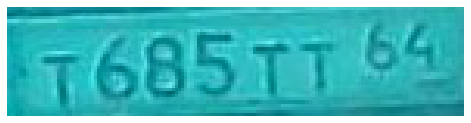

ValueError: not enough values to unpack (expected 3, got 2)

In [30]:


visualize_prediction_plate(np.random.choice(test_images), model, id_to_name={1: 'plate'}, thresh=0.95)



In [31]:
THRESHOLD_SCORE = 0.93
TRESHOLD_MASK = 0.05

preds = []
model.eval()


for file in tqdm.tqdm(test_images, position=0, leave=False):

    img = Image.open(file).convert('RGB')
    img_tensor = my_transforms(img)
    with torch.no_grad():
        predictions = model([img_tensor.to(device)])
    prediction = predictions[0]

    pred = dict()
    pred['file'] = file
    pred['nums'] = []

    for i in range(len(prediction['boxes'])):
        x_min, y_min, x_max, y_max = map(int, prediction['boxes'][i].tolist())
        label = int(prediction['labels'][i].cpu())
        score = float(prediction['scores'][i].cpu())
        mask = prediction['masks'][i][0, :, :].cpu().numpy()

        if score > THRESHOLD_SCORE:            
            # В разных версиях opencv этот метод возвращает разное число параметров
            contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
#             _,contours,_ = cv2.findContours((mask > TRESHOLD_MASK).astype(np.uint8), 1, 1)
            approx = simplify_contour(contours[0], n_corners=4)
            
            if approx is None:
                x0, y0 = x_min, y_min
                x1, y1 = x_max, y_min
                x2, y2 = x_min, y_max
                x3, y3 = x_max, y_max
            else:
                x0, y0 = approx[0][0][0], approx[0][0][1]
                x1, y1 = approx[1][0][0], approx[1][0][1]
                x2, y2 = approx[2][0][0], approx[2][0][1]
                x3, y3 = approx[3][0][0], approx[3][0][1]
                
            points = [[x0, y0], [x2, y2], [x1, y1],[x3, y3]]

            pred['nums'].append({
                'box': points,
                'bbox': [x_min, y_min, x_max, y_max],
            })

    preds.append(pred)   

    
with open(os.path.join(DATA_PATH, 'test.json'), 'w') as json_file:
    json.dump(preds, json_file, cls=npEncoder)

  9%|▉         | 281/3188 [00:25<05:22,  9.02it/s]

simplify_contour didnt coverege


 30%|███       | 962/3188 [01:29<03:33, 10.42it/s]

simplify_contour didnt coverege


In [32]:
class OCRDataset(Dataset):
    def __init__(self, marks, img_folder, alphabet, transforms=None):
        ocr_marks = []
        for items in marks:
            file_path = items['file']
            for box in items['nums']:
                
                ocr_marks.append({
                    'file': file_path,
                    'box': np.clip(box['box'], 0, None).tolist(),
                    'text': box['text'],
                    'boxed': False,
                })
                            
                # Добавим точки, запакованные в BoundingBox. 
                # Вместо аугментации rotate. Датасет будет в 2 раза больше
                
                #Клипаем, ибо есть отрицательные координаты
                points = np.clip(box['box'], 0, None) 
                x0, y0 = np.min(points[:, 0]), np.min(points[:, 1])
                x2, y2 = np.max(points[:, 0]), np.max(points[:, 1])

                ocr_marks.append({
                    'file': file_path,
                    'box': [x0, y0, x2, y2],
                    'text': box['text'],
                    'boxed': True,
                })
                
        self.marks = ocr_marks
        self.img_folder = img_folder
        self.transforms = transforms
        self.alphabet = alphabet
        
    def __getitem__(self, idx):
        item = self.marks[idx]
        img_path = os.path.join(self.img_folder, item["file"])
        img = cv2.imread(img_path)

        if item['boxed']:
            x_min, y_min, x_max, y_max = item['box']
            img = img[y_min:y_max, x_min:x_max]
        else:
            points = np.clip(np.array(item['box']), 0, None)
            img = four_point_transform(img, points)
            
        text = item['text']
        seq = [self.alphabet.find(char) + 1 for char in text]
        seq_len = len(seq)
        
        if self.transforms is not None:
            img = self.transforms(img)

        output = {
            'img': img,
            'text': text,
            'seq': seq,
            'seq_len': seq_len
        }
        
        return output
    
    
    def __len__(self):
        return len(self.marks)
    
    
class Resize(object):
    def __init__(self, size=(320, 64)):
        self.size = size

    def __call__(self, img):

        w_from, h_from = img.shape[1], img.shape[0]
        w_to, h_to = self.size
        
        # Сделаем разную интерполяцию при увеличении и уменьшении
        # Если увеличиваем картинку, меняем интерполяцию
        interpolation = cv2.INTER_AREA
        if w_to > w_from:
            interpolation = cv2.INTER_CUBIC
        
        img = cv2.resize(img, dsize=self.size, interpolation=interpolation)
        return img
    
my_ocr_transforms = transforms.Compose([
    Resize(size=(320, 64)),
    transforms.ToTensor()
])

def get_vocab_from_marks(marks):
    train_texts = []
    for item in marks:
        for num in item['nums']:
            train_texts.append(num['text'])

    counts = Counter(''.join(train_texts))
    alphabet = ''.join(set(''.join(train_texts)))
    corted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    char_to_idx = {item[0]: idx + 1 for idx, item in enumerate(corted_counts)}
    idx_to_char = {idx:char for char, idx in char_to_idx.items()}
    return char_to_idx, idx_to_char, alphabet

char_to_idx, idx_to_char, alphabet = get_vocab_from_marks(train_marks)

train_ocr_dataset = OCRDataset(
    marks=train_marks, 
    img_folder=DATA_PATH, 
    alphabet=alphabet,
    transforms=my_ocr_transforms
)
val_ocr_dataset = OCRDataset(
    marks=val_marks, 
    img_folder=DATA_PATH, 
    alphabet=alphabet,
    transforms=my_ocr_transforms
)

def collate_fn_ocr(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.
    Accepts list of dataset __get_item__ return values (dicts).
    Returns dict with same keys but values are either torch.Tensors of batched images, sequences, and so.
    """
    images, seqs, seq_lens, texts = [], [], [], []
    for sample in batch:
        images.append(sample["img"])
        seqs.extend(sample["seq"])
        seq_lens.append(sample["seq_len"])
        texts.append(sample["text"])
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq": seqs, "seq_len": seq_lens, "text": texts}
    return batch

train_ocr_loader = DataLoader(
    train_ocr_dataset, 
    batch_size=BATCH_SIZE_OCR, 
    drop_last=True,
    num_workers=0, # Почему-то у меня виснет DataLoader, если запустить несколько потоков
    collate_fn=collate_fn_ocr,
    timeout=0,
    shuffle=True # Чтобы повернутые дубли картинок не шли подряд
)

val_ocr_loader = DataLoader(
    val_ocr_dataset, 
    batch_size=BATCH_SIZE_OCR, 
    drop_last=False,
    num_workers=0,
    collate_fn=collate_fn_ocr, 
    timeout=0,
)

gc.collect()

7

In [22]:
class FeatureExtractor(nn.Module):
    
    def __init__(self, input_size=(64, 320), output_len=20):
        super(FeatureExtractor, self).__init__()
        
        h, w = input_size
        resnet = getattr(models, 'resnet18')(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])
        
        self.pool = nn.AvgPool2d(kernel_size=(h // 32, 1))        
        self.proj = nn.Conv2d(w // 32, output_len, kernel_size=1)
  
        self.num_output_features = self.cnn[-1][-1].bn2.num_features    
    
    def apply_projection(self, x):
        """Use convolution to increase width of a features.
        Accepts tensor of features (shaped B x C x H x W).
        Returns new tensor of features (shaped B x C x H x W').
        """
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        return x
   
    def forward(self, x):
        # Apply conv layers
        features = self.cnn(x)
        
        # Pool to make height == 1
        features = self.pool(features)
        
        # Apply projection to increase width
        features = self.apply_projection(features)
        
        return features
    
class SequencePredictor(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3, bidirectional=False):
        super(SequencePredictor, self).__init__()
        
        self.num_classes = num_classes        
        self.rnn = nn.GRU(input_size=input_size,
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       dropout=dropout,
                       bidirectional=bidirectional)
        
        fc_in = hidden_size if not bidirectional else 2 * hidden_size
        self.fc = nn.Linear(in_features=fc_in,
                         out_features=num_classes)
    
    def _init_hidden_(self, batch_size):
        """Initialize new tensor of zeroes for RNN hidden state.
        Accepts batch size.
        Returns tensor of zeros shaped (num_layers * num_directions, batch, hidden_size).
        """
        num_directions = 2 if self.rnn.bidirectional else 1
        return torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)
        
    def _prepare_features_(self, x):
        """Change dimensions of x to fit RNN expected input.
        Accepts tensor x shaped (B x (C=1) x H x W).
        Returns new tensor shaped (W x B x H).
        """
        x = x.squeeze(1)
        x = x.permute(2, 0, 1)
        return x
    
    def forward(self, x):
        x = self._prepare_features_(x)
        
        batch_size = x.size(1)
        h_0 = self._init_hidden_(batch_size)
        h_0 = h_0.to(x.device)
        x, h = self.rnn(x, h_0)
        
        x = self.fc(x)
        return x
    
class CRNN(nn.Module):
    
    def __init__(
        self, 
        alphabet=alphabet,
        cnn_input_size=(64, 320), 
        cnn_output_len=20,
        rnn_hidden_size=128, 
        rnn_num_layers=2, 
        rnn_dropout=0.3, 
        rnn_bidirectional=False
    ):
        super(CRNN, self).__init__()
        self.alphabet = alphabet
        
        self.features_extractor = FeatureExtractor(
            input_size=cnn_input_size, 
            output_len=cnn_output_len
        )
        
        self.sequence_predictor = SequencePredictor(
            input_size=self.features_extractor.num_output_features,
            hidden_size=rnn_hidden_size, 
            num_layers=rnn_num_layers,
            num_classes=(len(alphabet) + 1), 
            dropout=rnn_dropout,
            bidirectional=rnn_bidirectional
        )
    
    def forward(self, x):
        features = self.features_extractor(x)
        sequence = self.sequence_predictor(features)
        return sequence

In [23]:
crnn = CRNN()
# crnn.load_state_dict(torch.load(OCR_MODEL_PATH))
crnn.to(device);

In [24]:
optimizer = torch.optim.Adam(crnn.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5, verbose=True)

In [25]:
# Здесь тоже оставил пока обучение без валидации. 
# Может, здесь и стоит валидировать. 
# Но опять же, 1-2 эпох хватает, а значит модель видит почти все данные 
# в первый раз и лосс на трейне вполне отражает реальность

crnn.train()
for epoch in range(2):
    epoch_losses = []
    print_loss = []
    
    for i, batch in enumerate(tqdm.tqdm(train_ocr_loader, total=len(train_ocr_loader), leave=False, position=0)):
        images = batch["image"].to(device)
        seqs_gt = batch["seq"]
        seq_lens_gt = batch["seq_len"]

        seqs_pred = crnn(images).cpu()
        log_probs = F.log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()

        loss = F.ctc_loss(
            log_probs=log_probs,  # (T, N, C)
            targets=seqs_gt,  # N, S or sum(target_lengths)
            input_lengths=seq_lens_pred,  # N
            target_lengths=seq_lens_gt # N
        )  

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print_loss.append(loss.item())
        if (i + 1) % 20 == 0:
            mean_loss = np.mean(print_loss)
            print(f'Loss: {mean_loss:.7f}')
            scheduler.step(mean_loss)
            print_loss = [] 
    
        epoch_losses.append(loss.item())

    print(i, np.mean(epoch_losses))

  1%|          | 20/3016 [00:04<11:54,  4.19it/s]

Loss: 5.9496877


  1%|▏         | 40/3016 [00:09<12:12,  4.06it/s]

Loss: 3.8148619


  2%|▏         | 60/3016 [00:14<12:32,  3.93it/s]

Loss: 3.4919540


  3%|▎         | 80/3016 [00:19<12:10,  4.02it/s]

Loss: 3.3769149


  3%|▎         | 100/3016 [00:24<11:14,  4.32it/s]

Loss: 3.3033957


  4%|▍         | 120/3016 [00:29<13:13,  3.65it/s]

Loss: 3.2616628


  5%|▍         | 140/3016 [00:34<11:42,  4.10it/s]

Loss: 3.2137336


  5%|▌         | 160/3016 [00:39<10:57,  4.35it/s]

Loss: 3.1559420


  6%|▌         | 180/3016 [00:44<11:59,  3.94it/s]

Loss: 3.1014255


  7%|▋         | 200/3016 [00:49<12:09,  3.86it/s]

Loss: 3.0091602


  7%|▋         | 220/3016 [00:54<11:41,  3.99it/s]

Loss: 2.9547351


  8%|▊         | 240/3016 [00:59<11:16,  4.10it/s]

Loss: 2.8916778


  9%|▊         | 260/3016 [01:04<11:50,  3.88it/s]

Loss: 2.8069293


  9%|▉         | 280/3016 [01:09<11:16,  4.05it/s]

Loss: 2.7041814


 10%|▉         | 301/3016 [01:15<10:51,  4.17it/s]

Loss: 2.6305805


 11%|█         | 320/3016 [01:20<11:36,  3.87it/s]

Loss: 2.5201688


 11%|█▏        | 340/3016 [01:25<11:20,  3.93it/s]

Loss: 2.4097154


 12%|█▏        | 360/3016 [01:30<10:45,  4.12it/s]

Loss: 2.2591988


 13%|█▎        | 380/3016 [01:35<11:02,  3.98it/s]

Loss: 2.2155334


 13%|█▎        | 400/3016 [01:40<11:07,  3.92it/s]

Loss: 2.0951485


 14%|█▍        | 420/3016 [01:45<11:21,  3.81it/s]

Loss: 1.9846913


 15%|█▍        | 440/3016 [01:50<10:54,  3.94it/s]

Loss: 1.8580806


 15%|█▌        | 460/3016 [01:55<11:52,  3.59it/s]

Loss: 1.7983934


 16%|█▌        | 480/3016 [02:01<10:50,  3.90it/s]

Loss: 1.6904765


 17%|█▋        | 500/3016 [02:05<10:03,  4.17it/s]

Loss: 1.6271620


 17%|█▋        | 521/3016 [02:10<08:47,  4.73it/s]

Loss: 1.5277317


 18%|█▊        | 540/3016 [02:15<11:50,  3.49it/s]

Loss: 1.4432994


 19%|█▊        | 560/3016 [02:20<08:54,  4.60it/s]

Loss: 1.3822761


 19%|█▉        | 580/3016 [02:25<10:08,  4.00it/s]

Loss: 1.3830785


 20%|█▉        | 600/3016 [02:30<10:30,  3.83it/s]

Loss: 1.3303731


 21%|██        | 620/3016 [02:35<09:24,  4.25it/s]

Loss: 1.3111932


 21%|██        | 640/3016 [02:40<08:59,  4.41it/s]

Loss: 1.2885013


 22%|██▏       | 660/3016 [02:45<09:13,  4.25it/s]

Loss: 1.2239110


 23%|██▎       | 680/3016 [02:50<10:12,  3.81it/s]

Loss: 1.2067237


 23%|██▎       | 700/3016 [02:55<09:15,  4.17it/s]

Loss: 1.1721124


 24%|██▍       | 720/3016 [03:00<09:21,  4.09it/s]

Loss: 1.1453014


 25%|██▍       | 740/3016 [03:06<09:44,  3.90it/s]

Loss: 1.1935669


 25%|██▌       | 761/3016 [03:11<08:53,  4.23it/s]

Loss: 1.1300796


 26%|██▌       | 780/3016 [03:15<09:32,  3.90it/s]

Loss: 1.1540203


 27%|██▋       | 800/3016 [03:20<08:27,  4.37it/s]

Loss: 1.0867599


 27%|██▋       | 820/3016 [03:25<09:32,  3.83it/s]

Loss: 1.0978847


 28%|██▊       | 840/3016 [03:30<08:38,  4.19it/s]

Loss: 1.0874780


 29%|██▊       | 860/3016 [03:35<08:30,  4.22it/s]

Loss: 1.1121318


 29%|██▉       | 880/3016 [03:40<08:46,  4.06it/s]

Loss: 1.0587306


 30%|██▉       | 900/3016 [03:45<09:08,  3.86it/s]

Loss: 1.1045772


 31%|███       | 920/3016 [03:50<09:01,  3.87it/s]

Loss: 1.0984849


 31%|███       | 940/3016 [03:55<07:25,  4.66it/s]

Loss: 1.0458839


 32%|███▏      | 960/3016 [04:00<08:08,  4.21it/s]

Loss: 1.1084074


 32%|███▏      | 980/3016 [04:05<08:02,  4.22it/s]

Loss: 0.9969612


 33%|███▎      | 1000/3016 [04:10<08:16,  4.06it/s]

Loss: 1.0602331


 34%|███▍      | 1020/3016 [04:15<08:42,  3.82it/s]

Loss: 1.0439072


 34%|███▍      | 1040/3016 [04:20<07:52,  4.18it/s]

Loss: 1.0292377


 35%|███▌      | 1060/3016 [04:25<08:17,  3.93it/s]

Loss: 1.0059176


 36%|███▌      | 1080/3016 [04:31<08:18,  3.88it/s]

Loss: 0.9547866


 36%|███▋      | 1100/3016 [04:35<07:18,  4.37it/s]

Loss: 0.9519197


 37%|███▋      | 1120/3016 [04:41<07:28,  4.22it/s]

Loss: 0.9654546


 38%|███▊      | 1140/3016 [04:46<07:56,  3.94it/s]

Loss: 0.9121907


 38%|███▊      | 1160/3016 [04:51<07:13,  4.28it/s]

Loss: 0.9502666


 39%|███▉      | 1180/3016 [04:56<08:06,  3.78it/s]

Loss: 0.9473922


 40%|███▉      | 1200/3016 [05:01<06:56,  4.36it/s]

Loss: 0.9163305


 40%|████      | 1220/3016 [05:05<06:33,  4.56it/s]

Loss: 0.9055109


 41%|████      | 1240/3016 [05:10<07:02,  4.20it/s]

Loss: 0.9132423


 42%|████▏     | 1260/3016 [05:15<06:31,  4.49it/s]

Loss: 0.8836872


 42%|████▏     | 1280/3016 [05:20<07:08,  4.05it/s]

Loss: 0.9458920


 43%|████▎     | 1300/3016 [05:25<07:42,  3.71it/s]

Loss: 0.8652734


 44%|████▍     | 1320/3016 [05:30<07:29,  3.77it/s]

Loss: 0.8546674


 44%|████▍     | 1340/3016 [05:35<06:58,  4.01it/s]

Loss: 0.8941433


 45%|████▌     | 1360/3016 [05:40<06:44,  4.09it/s]

Loss: 0.8011731


 46%|████▌     | 1380/3016 [05:45<07:02,  3.87it/s]

Loss: 0.8076953


 46%|████▋     | 1400/3016 [05:50<06:53,  3.91it/s]

Loss: 0.7834176


 47%|████▋     | 1420/3016 [05:54<06:41,  3.98it/s]

Loss: 0.7823474


 48%|████▊     | 1440/3016 [05:59<05:59,  4.38it/s]

Loss: 0.7430844


 48%|████▊     | 1460/3016 [06:04<07:00,  3.70it/s]

Loss: 0.7310300


 49%|████▉     | 1480/3016 [06:09<06:33,  3.91it/s]

Loss: 0.7084582


 50%|████▉     | 1500/3016 [06:14<06:18,  4.00it/s]

Loss: 0.7177723


 50%|█████     | 1520/3016 [06:19<05:38,  4.42it/s]

Loss: 0.7315719


 51%|█████     | 1540/3016 [06:24<06:15,  3.93it/s]

Loss: 0.7374842


 52%|█████▏    | 1560/3016 [06:29<06:11,  3.92it/s]

Loss: 0.7030947


 52%|█████▏    | 1580/3016 [06:34<06:02,  3.97it/s]

Loss: 0.6962358


 53%|█████▎    | 1601/3016 [06:39<05:01,  4.70it/s]

Loss: 0.6376165


 54%|█████▎    | 1620/3016 [06:44<06:40,  3.49it/s]

Loss: 0.5962267


 54%|█████▍    | 1640/3016 [06:49<05:33,  4.12it/s]

Loss: 0.5977570


 55%|█████▌    | 1661/3016 [06:54<05:06,  4.42it/s]

Loss: 0.6057964


 56%|█████▌    | 1680/3016 [06:59<05:44,  3.88it/s]

Loss: 0.5558803


 56%|█████▋    | 1700/3016 [07:04<05:07,  4.29it/s]

Loss: 0.5207537


 57%|█████▋    | 1720/3016 [07:09<05:04,  4.26it/s]

Loss: 0.5387716


 58%|█████▊    | 1740/3016 [07:14<04:56,  4.30it/s]

Loss: 0.5125579


 58%|█████▊    | 1760/3016 [07:19<04:52,  4.29it/s]

Loss: 0.4780471


 59%|█████▉    | 1780/3016 [07:24<04:42,  4.38it/s]

Loss: 0.4663399


 60%|█████▉    | 1800/3016 [07:29<04:58,  4.08it/s]

Loss: 0.4418860


 60%|██████    | 1821/3016 [07:34<04:41,  4.24it/s]

Loss: 0.4145078


 61%|██████    | 1841/3016 [07:39<04:20,  4.51it/s]

Loss: 0.4554462


 62%|██████▏   | 1860/3016 [07:43<04:09,  4.63it/s]

Loss: 0.4094512


 62%|██████▏   | 1880/3016 [07:48<04:21,  4.34it/s]

Loss: 0.4048174


 63%|██████▎   | 1900/3016 [07:53<04:24,  4.22it/s]

Loss: 0.3822974


 64%|██████▎   | 1920/3016 [07:58<04:19,  4.22it/s]

Loss: 0.3695412


 64%|██████▍   | 1940/3016 [08:03<05:00,  3.59it/s]

Loss: 0.3810466


 65%|██████▍   | 1960/3016 [08:08<04:20,  4.06it/s]

Loss: 0.3945242


 66%|██████▌   | 1981/3016 [08:13<04:21,  3.96it/s]

Loss: 0.4004399


 66%|██████▋   | 2000/3016 [08:18<03:49,  4.43it/s]

Loss: 0.3770000


 67%|██████▋   | 2020/3016 [08:23<05:04,  3.28it/s]

Loss: 0.3362309


 68%|██████▊   | 2040/3016 [08:28<03:59,  4.07it/s]

Loss: 0.3726135


 68%|██████▊   | 2060/3016 [08:33<03:47,  4.20it/s]

Loss: 0.3744637


 69%|██████▉   | 2081/3016 [08:38<03:33,  4.38it/s]

Loss: 0.3761220


 70%|██████▉   | 2100/3016 [08:42<03:43,  4.09it/s]

Loss: 0.3095109


 70%|███████   | 2120/3016 [08:47<03:27,  4.31it/s]

Loss: 0.3057388


 71%|███████   | 2140/3016 [08:53<03:47,  3.84it/s]

Loss: 0.3223565


 72%|███████▏  | 2160/3016 [08:57<03:00,  4.74it/s]

Loss: 0.2902190


 72%|███████▏  | 2180/3016 [09:02<03:38,  3.82it/s]

Loss: 0.2899710


 73%|███████▎  | 2200/3016 [09:07<03:00,  4.52it/s]

Loss: 0.3200703


 74%|███████▎  | 2221/3016 [09:12<03:14,  4.08it/s]

Loss: 0.2654776


 74%|███████▍  | 2240/3016 [09:17<03:11,  4.05it/s]

Loss: 0.2818897


 75%|███████▍  | 2260/3016 [09:22<02:58,  4.25it/s]

Loss: 0.2883679


 76%|███████▌  | 2280/3016 [09:27<02:49,  4.34it/s]

Loss: 0.2872014


 76%|███████▋  | 2300/3016 [09:32<03:06,  3.84it/s]

Loss: 0.2955382


 77%|███████▋  | 2320/3016 [09:37<02:47,  4.15it/s]

Loss: 0.2898512


 78%|███████▊  | 2340/3016 [09:42<02:56,  3.84it/s]

Loss: 0.3054411


 78%|███████▊  | 2360/3016 [09:47<02:30,  4.35it/s]

Loss: 0.2573201


 79%|███████▉  | 2380/3016 [09:51<02:21,  4.51it/s]

Loss: 0.2249240


 80%|███████▉  | 2401/3016 [09:57<02:13,  4.62it/s]

Loss: 0.2254354


 80%|████████  | 2420/3016 [10:01<02:36,  3.80it/s]

Loss: 0.2566603


 81%|████████  | 2441/3016 [10:06<02:06,  4.53it/s]

Loss: 0.2456563


 82%|████████▏ | 2460/3016 [10:11<02:29,  3.72it/s]

Loss: 0.2671020


 82%|████████▏ | 2480/3016 [10:16<02:10,  4.10it/s]

Loss: 0.2377564


 83%|████████▎ | 2500/3016 [10:21<02:01,  4.23it/s]

Loss: 0.2666285


 84%|████████▎ | 2520/3016 [10:26<01:50,  4.50it/s]

Loss: 0.2382095


 84%|████████▍ | 2540/3016 [10:31<01:58,  4.03it/s]

Loss: 0.2645272


 85%|████████▍ | 2560/3016 [10:36<02:07,  3.57it/s]

Loss: 0.2412644


 86%|████████▌ | 2580/3016 [10:41<01:52,  3.89it/s]

Loss: 0.2034673


 86%|████████▌ | 2600/3016 [10:46<01:47,  3.87it/s]

Loss: 0.2892532


 87%|████████▋ | 2620/3016 [10:51<01:36,  4.10it/s]

Loss: 0.2369862


 88%|████████▊ | 2640/3016 [10:56<01:40,  3.74it/s]

Loss: 0.2543442


 88%|████████▊ | 2660/3016 [11:01<01:26,  4.13it/s]

Loss: 0.2184113


 89%|████████▉ | 2680/3016 [11:06<01:11,  4.70it/s]

Loss: 0.2225539


 90%|████████▉ | 2700/3016 [11:11<01:24,  3.72it/s]

Loss: 0.2417607


 90%|█████████ | 2720/3016 [11:16<01:09,  4.26it/s]

Loss: 0.2098976


 91%|█████████ | 2740/3016 [11:21<01:08,  4.02it/s]

Loss: 0.1960374


 92%|█████████▏| 2760/3016 [11:26<01:01,  4.18it/s]

Loss: 0.2390033


 92%|█████████▏| 2780/3016 [11:31<00:54,  4.34it/s]

Loss: 0.2411332


 93%|█████████▎| 2800/3016 [11:36<00:51,  4.16it/s]

Loss: 0.2288345


 94%|█████████▎| 2820/3016 [11:41<00:48,  4.02it/s]

Loss: 0.2185053


 94%|█████████▍| 2840/3016 [11:46<00:42,  4.17it/s]

Loss: 0.2573730


 95%|█████████▍| 2861/3016 [11:51<00:35,  4.39it/s]

Loss: 0.2483920


 95%|█████████▌| 2880/3016 [11:56<00:36,  3.77it/s]

Loss: 0.2345612


 96%|█████████▌| 2900/3016 [12:01<00:29,  3.87it/s]

Loss: 0.2326946


 97%|█████████▋| 2920/3016 [12:06<00:21,  4.42it/s]

Loss: 0.2076105


 97%|█████████▋| 2940/3016 [12:11<00:18,  4.03it/s]

Loss: 0.1952625


 98%|█████████▊| 2960/3016 [12:16<00:14,  3.95it/s]

Loss: 0.1807088


 99%|█████████▉| 2980/3016 [12:21<00:08,  4.31it/s]

Loss: 0.1941037


 99%|█████████▉| 3000/3016 [12:26<00:03,  4.02it/s]

Loss: 0.2431519


  0%|          | 0/3016 [00:00<?, ?it/s]           

3015 0.9806556845311105


  1%|          | 20/3016 [00:04<11:13,  4.45it/s]

Loss: 0.1874857


  1%|▏         | 40/3016 [00:09<11:50,  4.19it/s]

Loss: 0.1803015


  2%|▏         | 61/3016 [00:14<10:55,  4.51it/s]

Loss: 0.2075257


  3%|▎         | 80/3016 [00:19<11:58,  4.09it/s]

Loss: 0.1581628


  3%|▎         | 100/3016 [00:24<11:33,  4.21it/s]

Loss: 0.1391114


  4%|▍         | 120/3016 [00:28<12:24,  3.89it/s]

Loss: 0.1813063


  5%|▍         | 140/3016 [00:34<14:46,  3.25it/s]

Loss: 0.2327118


  5%|▌         | 160/3016 [00:38<11:07,  4.28it/s]

Loss: 0.1845564


  6%|▌         | 180/3016 [00:44<12:39,  3.74it/s]

Loss: 0.1879469


  7%|▋         | 200/3016 [00:48<11:41,  4.01it/s]

Loss: 0.1600992


  7%|▋         | 220/3016 [00:53<12:33,  3.71it/s]

Loss: 0.1960832


  8%|▊         | 240/3016 [00:58<12:24,  3.73it/s]

Loss: 0.1819622


  9%|▊         | 260/3016 [01:03<10:33,  4.35it/s]

Loss: 0.1707291


  9%|▉         | 280/3016 [01:08<11:55,  3.82it/s]

Loss: 0.1756088


 10%|▉         | 300/3016 [01:13<12:11,  3.71it/s]

Loss: 0.1891330


 11%|█         | 320/3016 [01:18<12:04,  3.72it/s]

Loss: 0.1261696


 11%|█▏        | 340/3016 [01:23<11:11,  3.98it/s]

Loss: 0.1318784


 12%|█▏        | 360/3016 [01:28<10:57,  4.04it/s]

Loss: 0.1688230


 13%|█▎        | 380/3016 [01:33<11:04,  3.97it/s]

Loss: 0.1486159


 13%|█▎        | 400/3016 [01:38<11:27,  3.81it/s]

Loss: 0.1540456


 14%|█▍        | 420/3016 [01:42<10:49,  4.00it/s]

Loss: 0.1741136


 15%|█▍        | 440/3016 [01:47<10:39,  4.03it/s]

Loss: 0.1383404


 15%|█▌        | 460/3016 [01:52<09:47,  4.35it/s]

Loss: 0.1662664


 16%|█▌        | 480/3016 [01:57<10:13,  4.13it/s]

Loss: 0.1588462


 17%|█▋        | 500/3016 [02:02<10:38,  3.94it/s]

Loss: 0.2129732


 17%|█▋        | 520/3016 [02:07<09:46,  4.26it/s]

Loss: 0.1491399


 18%|█▊        | 541/3016 [02:12<09:02,  4.56it/s]

Loss: 0.2140030
Epoch   177: reducing learning rate of group 0 to 1.5000e-04.


 19%|█▊        | 560/3016 [02:17<11:12,  3.65it/s]

Loss: 0.1087306


 19%|█▉        | 581/3016 [02:22<09:49,  4.13it/s]

Loss: 0.1443092


 20%|█▉        | 600/3016 [02:26<10:07,  3.98it/s]

Loss: 0.1663662


 21%|██        | 620/3016 [02:32<10:00,  3.99it/s]

Loss: 0.1906516


 21%|██        | 640/3016 [02:36<09:22,  4.22it/s]

Loss: 0.1755882


 22%|██▏       | 660/3016 [02:41<09:11,  4.27it/s]

Loss: 0.1692246


 23%|██▎       | 681/3016 [02:47<09:21,  4.16it/s]

Loss: 0.1669319


 23%|██▎       | 700/3016 [02:51<08:58,  4.30it/s]

Loss: 0.1051460


 24%|██▍       | 720/3016 [02:56<07:58,  4.79it/s]

Loss: 0.1688517


 25%|██▍       | 740/3016 [03:01<09:43,  3.90it/s]

Loss: 0.1620389


 25%|██▌       | 760/3016 [03:06<10:09,  3.70it/s]

Loss: 0.1260221


 26%|██▌       | 780/3016 [03:12<10:44,  3.47it/s]

Loss: 0.1601141


 27%|██▋       | 800/3016 [03:17<07:45,  4.76it/s]

Loss: 0.1233785


 27%|██▋       | 820/3016 [03:22<10:17,  3.56it/s]

Loss: 0.1418693


 28%|██▊       | 840/3016 [03:27<09:45,  3.72it/s]

Loss: 0.1898390


 29%|██▊       | 860/3016 [03:31<08:27,  4.25it/s]

Loss: 0.1447870


 29%|██▉       | 880/3016 [03:36<08:44,  4.07it/s]

Loss: 0.1158073


 30%|██▉       | 900/3016 [03:42<09:19,  3.78it/s]

Loss: 0.1405624


 31%|███       | 920/3016 [03:47<09:44,  3.59it/s]

Loss: 0.1549811
Epoch   196: reducing learning rate of group 0 to 7.5000e-05.


 31%|███       | 940/3016 [03:52<09:00,  3.84it/s]

Loss: 0.1234672


 32%|███▏      | 960/3016 [03:57<09:03,  3.78it/s]

Loss: 0.1722799


 32%|███▏      | 980/3016 [04:02<08:24,  4.04it/s]

Loss: 0.1308180


 33%|███▎      | 1000/3016 [04:07<08:45,  3.84it/s]

Loss: 0.1111010


 34%|███▍      | 1020/3016 [04:12<07:53,  4.22it/s]

Loss: 0.1402155


 34%|███▍      | 1040/3016 [04:17<08:15,  3.99it/s]

Loss: 0.1449478


 35%|███▌      | 1060/3016 [04:22<07:55,  4.11it/s]

Loss: 0.1790698


 36%|███▌      | 1080/3016 [04:27<07:20,  4.39it/s]

Loss: 0.1007377


 36%|███▋      | 1100/3016 [04:32<08:26,  3.78it/s]

Loss: 0.1152962


 37%|███▋      | 1120/3016 [04:37<07:30,  4.21it/s]

Loss: 0.1388047


 38%|███▊      | 1140/3016 [04:42<08:39,  3.61it/s]

Loss: 0.1477151


 38%|███▊      | 1160/3016 [04:47<07:39,  4.03it/s]

Loss: 0.1263790


 39%|███▉      | 1181/3016 [04:52<07:03,  4.33it/s]

Loss: 0.1537407


 40%|███▉      | 1201/3016 [04:57<07:04,  4.28it/s]

Loss: 0.1407449


 40%|████      | 1220/3016 [05:02<07:14,  4.14it/s]

Loss: 0.1399102


 41%|████      | 1240/3016 [05:07<07:37,  3.88it/s]

Loss: 0.1317119


 42%|████▏     | 1260/3016 [05:12<06:40,  4.39it/s]

Loss: 0.1369356


 42%|████▏     | 1280/3016 [05:16<07:21,  3.93it/s]

Loss: 0.1299685


 43%|████▎     | 1300/3016 [05:21<07:30,  3.81it/s]

Loss: 0.1404959
Epoch   215: reducing learning rate of group 0 to 3.7500e-05.


 44%|████▍     | 1320/3016 [05:27<06:47,  4.16it/s]

Loss: 0.1165123


 44%|████▍     | 1340/3016 [05:31<07:18,  3.82it/s]

Loss: 0.1434486


 45%|████▌     | 1360/3016 [05:36<07:07,  3.88it/s]

Loss: 0.1238664


 46%|████▌     | 1380/3016 [05:41<07:05,  3.85it/s]

Loss: 0.1210265


 46%|████▋     | 1400/3016 [05:46<06:34,  4.09it/s]

Loss: 0.1566693


 47%|████▋     | 1421/3016 [05:52<05:55,  4.48it/s]

Loss: 0.1510877


 48%|████▊     | 1440/3016 [05:56<06:58,  3.77it/s]

Loss: 0.1647947


 48%|████▊     | 1460/3016 [06:01<06:12,  4.18it/s]

Loss: 0.1273223


 49%|████▉     | 1480/3016 [06:06<06:09,  4.16it/s]

Loss: 0.1353990


 50%|████▉     | 1500/3016 [06:11<05:41,  4.44it/s]

Loss: 0.1302428


 50%|█████     | 1520/3016 [06:16<05:54,  4.22it/s]

Loss: 0.1345226
Epoch   226: reducing learning rate of group 0 to 1.8750e-05.


 51%|█████     | 1540/3016 [06:21<06:01,  4.08it/s]

Loss: 0.1171856


 52%|█████▏    | 1560/3016 [06:26<07:04,  3.43it/s]

Loss: 0.1312382


 52%|█████▏    | 1580/3016 [06:31<05:48,  4.12it/s]

Loss: 0.1398916


 53%|█████▎    | 1600/3016 [06:36<05:57,  3.96it/s]

Loss: 0.1620935


 54%|█████▎    | 1620/3016 [06:41<05:42,  4.07it/s]

Loss: 0.0975528


 54%|█████▍    | 1640/3016 [06:46<05:27,  4.20it/s]

Loss: 0.1454251


 55%|█████▌    | 1660/3016 [06:51<05:17,  4.27it/s]

Loss: 0.1383311


 56%|█████▌    | 1680/3016 [06:56<05:41,  3.91it/s]

Loss: 0.1582498


 56%|█████▋    | 1701/3016 [07:01<05:51,  3.74it/s]

Loss: 0.1426133


 57%|█████▋    | 1720/3016 [07:06<05:16,  4.09it/s]

Loss: 0.1290499


 58%|█████▊    | 1740/3016 [07:10<04:24,  4.82it/s]

Loss: 0.1112999


 58%|█████▊    | 1761/3016 [07:15<04:38,  4.51it/s]

Loss: 0.1526628


 59%|█████▉    | 1781/3016 [07:20<04:26,  4.63it/s]

Loss: 0.1517518


 60%|█████▉    | 1800/3016 [07:25<04:59,  4.07it/s]

Loss: 0.1167838


 60%|██████    | 1820/3016 [07:30<05:12,  3.83it/s]

Loss: 0.1417948


 61%|██████    | 1840/3016 [07:35<05:05,  3.85it/s]

Loss: 0.1415003
Epoch   242: reducing learning rate of group 0 to 9.3750e-06.


 62%|██████▏   | 1860/3016 [07:39<04:33,  4.23it/s]

Loss: 0.1517357


 62%|██████▏   | 1880/3016 [07:44<05:06,  3.70it/s]

Loss: 0.1326172


 63%|██████▎   | 1900/3016 [07:49<04:25,  4.20it/s]

Loss: 0.1271894


 64%|██████▎   | 1921/3016 [07:54<04:22,  4.16it/s]

Loss: 0.0939954


 64%|██████▍   | 1940/3016 [07:59<04:34,  3.91it/s]

Loss: 0.1342280


 65%|██████▍   | 1960/3016 [08:04<04:23,  4.01it/s]

Loss: 0.1115431


 66%|██████▌   | 1980/3016 [08:08<03:30,  4.93it/s]

Loss: 0.1092657


 66%|██████▋   | 2000/3016 [08:13<03:44,  4.52it/s]

Loss: 0.1576248


 67%|██████▋   | 2020/3016 [08:18<03:39,  4.54it/s]

Loss: 0.1141260


 68%|██████▊   | 2040/3016 [08:23<04:19,  3.77it/s]

Loss: 0.0971424


 68%|██████▊   | 2060/3016 [08:28<03:45,  4.24it/s]

Loss: 0.1305991


 69%|██████▉   | 2080/3016 [08:33<03:58,  3.92it/s]

Loss: 0.1460682


 70%|██████▉   | 2100/3016 [08:38<03:52,  3.94it/s]

Loss: 0.1079376


 70%|███████   | 2120/3016 [08:43<03:05,  4.84it/s]

Loss: 0.1627598


 71%|███████   | 2140/3016 [08:47<03:18,  4.41it/s]

Loss: 0.1480568
Epoch   257: reducing learning rate of group 0 to 4.6875e-06.


 72%|███████▏  | 2160/3016 [08:53<03:43,  3.83it/s]

Loss: 0.1404346


 72%|███████▏  | 2180/3016 [08:58<03:38,  3.83it/s]

Loss: 0.1595737


 73%|███████▎  | 2200/3016 [09:02<03:18,  4.11it/s]

Loss: 0.1323204


 74%|███████▎  | 2220/3016 [09:08<03:38,  3.65it/s]

Loss: 0.1207801


 74%|███████▍  | 2240/3016 [09:13<03:16,  3.94it/s]

Loss: 0.1209806


 75%|███████▍  | 2260/3016 [09:18<03:00,  4.19it/s]

Loss: 0.1474054


 76%|███████▌  | 2280/3016 [09:23<03:19,  3.70it/s]

Loss: 0.1354481


 76%|███████▋  | 2300/3016 [09:28<03:17,  3.62it/s]

Loss: 0.1077659


 77%|███████▋  | 2320/3016 [09:33<02:49,  4.11it/s]

Loss: 0.1107821


 78%|███████▊  | 2341/3016 [09:38<02:49,  3.98it/s]

Loss: 0.1205059


 78%|███████▊  | 2360/3016 [09:43<02:34,  4.24it/s]

Loss: 0.1274111
Epoch   268: reducing learning rate of group 0 to 2.3437e-06.


 79%|███████▉  | 2380/3016 [09:47<02:25,  4.36it/s]

Loss: 0.1528657


 80%|███████▉  | 2400/3016 [09:52<02:23,  4.29it/s]

Loss: 0.1893082


 80%|████████  | 2420/3016 [09:57<02:31,  3.93it/s]

Loss: 0.1195595


 81%|████████  | 2440/3016 [10:02<02:19,  4.14it/s]

Loss: 0.1433926


 82%|████████▏ | 2460/3016 [10:07<02:07,  4.36it/s]

Loss: 0.1349094


 82%|████████▏ | 2480/3016 [10:11<01:58,  4.51it/s]

Loss: 0.1325211


 83%|████████▎ | 2501/3016 [10:17<02:06,  4.06it/s]

Loss: 0.1388306


 84%|████████▎ | 2520/3016 [10:21<02:02,  4.06it/s]

Loss: 0.1592128


 84%|████████▍ | 2540/3016 [10:26<02:00,  3.95it/s]

Loss: 0.1017607


 85%|████████▍ | 2560/3016 [10:31<01:56,  3.91it/s]

Loss: 0.1588938


 86%|████████▌ | 2581/3016 [10:36<01:35,  4.56it/s]

Loss: 0.1867835
Epoch   279: reducing learning rate of group 0 to 1.1719e-06.


 86%|████████▌ | 2600/3016 [10:41<01:40,  4.13it/s]

Loss: 0.1381571


 87%|████████▋ | 2620/3016 [10:46<01:37,  4.07it/s]

Loss: 0.1501967


 88%|████████▊ | 2641/3016 [10:51<01:30,  4.12it/s]

Loss: 0.1193530


 88%|████████▊ | 2661/3016 [10:56<01:17,  4.55it/s]

Loss: 0.1263622


 89%|████████▉ | 2680/3016 [11:01<01:20,  4.17it/s]

Loss: 0.1363106


 90%|████████▉ | 2700/3016 [11:05<01:18,  4.04it/s]

Loss: 0.1169433


 90%|█████████ | 2720/3016 [11:10<01:15,  3.94it/s]

Loss: 0.1289838


 91%|█████████ | 2740/3016 [11:16<01:13,  3.76it/s]

Loss: 0.1404003


 92%|█████████▏| 2760/3016 [11:21<01:01,  4.15it/s]

Loss: 0.1388499


 92%|█████████▏| 2781/3016 [11:25<00:53,  4.37it/s]

Loss: 0.1395283


 93%|█████████▎| 2800/3016 [11:30<00:57,  3.78it/s]

Loss: 0.1234186
Epoch   290: reducing learning rate of group 0 to 5.8594e-07.


 94%|█████████▎| 2820/3016 [11:35<00:51,  3.81it/s]

Loss: 0.1711278


 94%|█████████▍| 2840/3016 [11:40<00:40,  4.32it/s]

Loss: 0.1384288


 95%|█████████▍| 2861/3016 [11:44<00:33,  4.68it/s]

Loss: 0.1448731


 96%|█████████▌| 2881/3016 [11:50<00:30,  4.46it/s]

Loss: 0.1278910


 96%|█████████▌| 2900/3016 [11:54<00:29,  3.96it/s]

Loss: 0.1520255


 97%|█████████▋| 2920/3016 [11:59<00:26,  3.57it/s]

Loss: 0.1619715


 97%|█████████▋| 2940/3016 [12:05<00:20,  3.67it/s]

Loss: 0.1288938


 98%|█████████▊| 2960/3016 [12:10<00:13,  4.19it/s]

Loss: 0.1615288


 99%|█████████▉| 2980/3016 [12:15<00:09,  3.92it/s]

Loss: 0.1157297


 99%|█████████▉| 3000/3016 [12:20<00:03,  4.08it/s]

Loss: 0.1577185


3015 0.14462363368903214


In [26]:
torch.save(crnn.state_dict(), OCR_MODEL_PATH)

In [33]:
test_marks = load_json(os.path.join(DATA_PATH, 'test.json'))
crnn.eval()
resizer = Resize()

file_name_result = [] 
plates_string_result = []

for item in tqdm.tqdm(test_marks, leave=False, position=0):

    img_path = item["file"]
    img = cv2.imread(img_path)

    results_to_sort = []
    for box in item['nums']:
        x_min, y_min, x_max, y_max = box['bbox']
        img_bbox = resizer(img[y_min:y_max, x_min:x_max])
        img_bbox = my_transforms(img_bbox)
        img_bbox = img_bbox.unsqueeze(0)


        points = np.clip(np.array(box['box']), 0, None)
        img_polygon = resizer(four_point_transform(img, points))
        img_polygon = my_transforms(img_polygon)
        img_polygon = img_polygon.unsqueeze(0)

        preds_bbox = crnn(img_bbox.to(device)).cpu().detach()
        preds_poly = crnn(img_polygon.to(device)).cpu().detach()

        preds = preds_poly + preds_bbox
        num_text = decode(preds, alphabet)[0]

        results_to_sort.append((x_min, num_text))

    results = sorted(results_to_sort, key=lambda x: x[0])
    num_list = [x[1] for x in results]

    plates_string = ' '.join(num_list)
    file_name = img_path[img_path.find('test/'):]

    file_name_result.append(file_name)
    plates_string_result.append(plates_string)
    
df_submit = pd.DataFrame({'file_name': file_name_result, 'plates_string': plates_string_result})
df_submit.to_csv('submission_03.csv', index=False)